# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

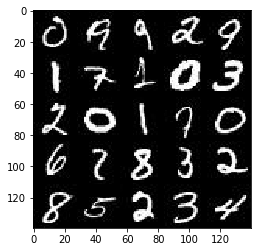

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

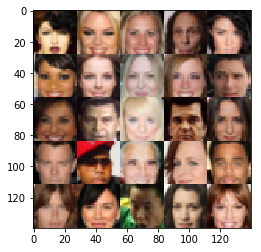

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(dtype=tf.float32, 
                                shape=(None, image_width, image_height, image_channels), 
                                name='input_real') 
    input_z = tf.placeholder(dtype=tf.float32, 
                             shape=(None, z_dim), 
                             name='input_z')
    lr = tf.placeholder(dtype=tf.float32, 
                        name='learning_rate')

    return (input_real, input_z, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        # Input layer is 28x28x3
        conv1 = tf.layers.conv2d(inputs=images, 
                                 filters=64, 
                                 kernel_size=5, 
                                 strides=2, 
                                 padding='same')
        relu1 = tf.maximum(conv1*alpha, conv1)
        # 14x14x64
        
        conv2 = tf.layers.conv2d(inputs=relu1, 
                                 filters=256, 
                                 kernel_size=5, 
                                 strides=2, 
                                 padding='same')
        norm2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(norm2*alpha, norm2)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

    return (output, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        
        alpha = 0.2
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1*alpha, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2*alpha, x2)
        # 14x14x64 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 3, strides=2, padding='same')
        # 28x28x3 now
        
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    #tf.reset_default_graph()
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    (input_real, input_z, lr) = model_inputs(image_width, 
                                             image_height, 
                                             image_channels, 
                                             z_dim)
    
    (d_loss, g_loss) = model_loss(input_real, 
                                  input_z, 
                                  image_channels)
    
    (d_train_opt, g_train_opt) = model_opt(d_loss, 
                                           g_loss, 
                                           lr, 
                                           beta1)
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                feed_dict = {input_real : batch_images, 
                             input_z : batch_z,
                             lr : learning_rate}
                
                _ = sess.run(d_train_opt, feed_dict=feed_dict)
                _ = sess.run(g_train_opt, feed_dict=feed_dict)
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_d_loss = d_loss.eval(feed_dict)
                    train_g_loss = g_loss.eval(feed_dict)
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_d_loss),
                          "Generator Loss: {:.4f}".format(train_g_loss))
                
                if steps % 100 == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3269... Generator Loss: 2.1601
Epoch 1/2... Discriminator Loss: 2.2234... Generator Loss: 0.2587
Epoch 1/2... Discriminator Loss: 1.1092... Generator Loss: 1.5405
Epoch 1/2... Discriminator Loss: 4.2094... Generator Loss: 0.0183
Epoch 1/2... Discriminator Loss: 1.7595... Generator Loss: 0.5760
Epoch 1/2... Discriminator Loss: 2.2712... Generator Loss: 0.1653
Epoch 1/2... Discriminator Loss: 1.7561... Generator Loss: 0.2471
Epoch 1/2... Discriminator Loss: 2.2237... Generator Loss: 0.1608
Epoch 1/2... Discriminator Loss: 2.9611... Generator Loss: 0.0633
Epoch 1/2... Discriminator Loss: 1.7441... Generator Loss: 1.6968


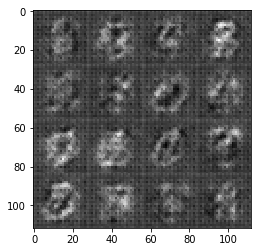

Epoch 1/2... Discriminator Loss: 0.4630... Generator Loss: 2.1506
Epoch 1/2... Discriminator Loss: 1.0363... Generator Loss: 3.3698
Epoch 1/2... Discriminator Loss: 1.1681... Generator Loss: 1.8298
Epoch 1/2... Discriminator Loss: 0.5789... Generator Loss: 2.8215
Epoch 1/2... Discriminator Loss: 0.9115... Generator Loss: 3.0678
Epoch 1/2... Discriminator Loss: 0.7254... Generator Loss: 2.0442
Epoch 1/2... Discriminator Loss: 0.8460... Generator Loss: 1.8467
Epoch 1/2... Discriminator Loss: 0.7063... Generator Loss: 1.7628
Epoch 1/2... Discriminator Loss: 0.4416... Generator Loss: 4.2533
Epoch 1/2... Discriminator Loss: 0.4073... Generator Loss: 3.0685


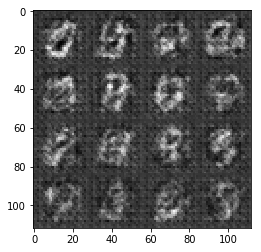

Epoch 1/2... Discriminator Loss: 0.3594... Generator Loss: 3.4355
Epoch 1/2... Discriminator Loss: 0.2232... Generator Loss: 4.9352
Epoch 1/2... Discriminator Loss: 0.1814... Generator Loss: 2.7657
Epoch 1/2... Discriminator Loss: 0.2891... Generator Loss: 5.9121
Epoch 1/2... Discriminator Loss: 0.3842... Generator Loss: 3.5907
Epoch 1/2... Discriminator Loss: 0.1363... Generator Loss: 3.4155
Epoch 1/2... Discriminator Loss: 0.9205... Generator Loss: 1.4361
Epoch 1/2... Discriminator Loss: 0.1647... Generator Loss: 2.8293
Epoch 1/2... Discriminator Loss: 0.5716... Generator Loss: 7.5034
Epoch 1/2... Discriminator Loss: 0.5028... Generator Loss: 2.0118


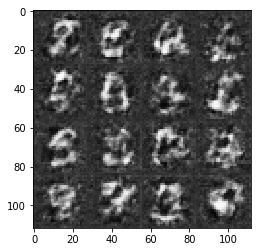

Epoch 1/2... Discriminator Loss: 0.1074... Generator Loss: 4.9735
Epoch 1/2... Discriminator Loss: 0.6043... Generator Loss: 8.6878
Epoch 1/2... Discriminator Loss: 0.5002... Generator Loss: 1.4925
Epoch 1/2... Discriminator Loss: 0.7215... Generator Loss: 0.9246
Epoch 1/2... Discriminator Loss: 0.2457... Generator Loss: 7.0753
Epoch 1/2... Discriminator Loss: 2.5547... Generator Loss: 9.2182
Epoch 1/2... Discriminator Loss: 0.2073... Generator Loss: 4.0793
Epoch 1/2... Discriminator Loss: 0.1214... Generator Loss: 5.0004
Epoch 1/2... Discriminator Loss: 0.1235... Generator Loss: 3.4774
Epoch 1/2... Discriminator Loss: 0.7192... Generator Loss: 1.0056


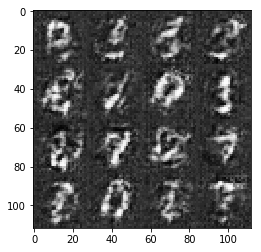

Epoch 1/2... Discriminator Loss: 1.8995... Generator Loss: 0.2467
Epoch 1/2... Discriminator Loss: 0.4372... Generator Loss: 1.4089
Epoch 1/2... Discriminator Loss: 1.0592... Generator Loss: 0.7331
Epoch 1/2... Discriminator Loss: 0.2378... Generator Loss: 5.9114
Epoch 1/2... Discriminator Loss: 0.2039... Generator Loss: 3.1865
Epoch 1/2... Discriminator Loss: 0.0672... Generator Loss: 6.7174
Epoch 1/2... Discriminator Loss: 0.0358... Generator Loss: 6.9180
Epoch 1/2... Discriminator Loss: 3.8128... Generator Loss: 0.0421
Epoch 1/2... Discriminator Loss: 0.2179... Generator Loss: 2.7394
Epoch 1/2... Discriminator Loss: 0.2709... Generator Loss: 1.9078


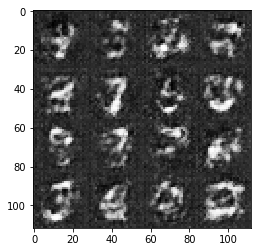

Epoch 1/2... Discriminator Loss: 0.0938... Generator Loss: 3.4903
Epoch 1/2... Discriminator Loss: 0.1851... Generator Loss: 2.5427
Epoch 1/2... Discriminator Loss: 0.2284... Generator Loss: 6.2372
Epoch 1/2... Discriminator Loss: 0.0558... Generator Loss: 4.5864
Epoch 1/2... Discriminator Loss: 0.0541... Generator Loss: 4.2638
Epoch 1/2... Discriminator Loss: 0.0937... Generator Loss: 6.6813
Epoch 1/2... Discriminator Loss: 0.0804... Generator Loss: 3.6810
Epoch 1/2... Discriminator Loss: 0.0502... Generator Loss: 6.1186
Epoch 1/2... Discriminator Loss: 0.0968... Generator Loss: 7.2928
Epoch 1/2... Discriminator Loss: 0.0368... Generator Loss: 4.8124


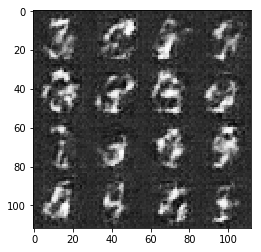

Epoch 1/2... Discriminator Loss: 1.0955... Generator Loss: 0.7064
Epoch 1/2... Discriminator Loss: 3.9993... Generator Loss: 0.0302
Epoch 1/2... Discriminator Loss: 2.3341... Generator Loss: 0.1841
Epoch 1/2... Discriminator Loss: 1.0846... Generator Loss: 0.6575
Epoch 1/2... Discriminator Loss: 1.5812... Generator Loss: 0.4498
Epoch 1/2... Discriminator Loss: 0.5401... Generator Loss: 1.2504
Epoch 1/2... Discriminator Loss: 0.6450... Generator Loss: 1.1479
Epoch 1/2... Discriminator Loss: 0.2092... Generator Loss: 2.2610
Epoch 1/2... Discriminator Loss: 0.3493... Generator Loss: 3.9270
Epoch 1/2... Discriminator Loss: 0.4042... Generator Loss: 1.6248


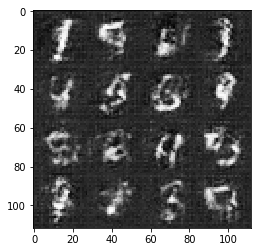

Epoch 1/2... Discriminator Loss: 0.1033... Generator Loss: 3.2342
Epoch 1/2... Discriminator Loss: 0.0918... Generator Loss: 2.9557
Epoch 1/2... Discriminator Loss: 0.1816... Generator Loss: 2.4837
Epoch 1/2... Discriminator Loss: 0.3344... Generator Loss: 2.0148
Epoch 1/2... Discriminator Loss: 0.4567... Generator Loss: 1.3283
Epoch 1/2... Discriminator Loss: 0.0674... Generator Loss: 3.6071
Epoch 1/2... Discriminator Loss: 0.0750... Generator Loss: 6.9872
Epoch 1/2... Discriminator Loss: 0.0500... Generator Loss: 5.6799
Epoch 1/2... Discriminator Loss: 0.2093... Generator Loss: 9.3613
Epoch 1/2... Discriminator Loss: 0.0813... Generator Loss: 4.1586


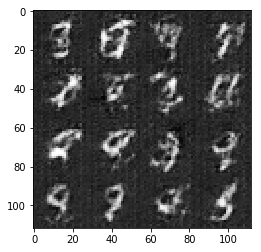

Epoch 1/2... Discriminator Loss: 0.0359... Generator Loss: 4.5479
Epoch 1/2... Discriminator Loss: 0.0656... Generator Loss: 3.7915
Epoch 1/2... Discriminator Loss: 0.4857... Generator Loss: 1.2645
Epoch 1/2... Discriminator Loss: 0.9343... Generator Loss: 5.8672
Epoch 1/2... Discriminator Loss: 3.1565... Generator Loss: 6.7754
Epoch 1/2... Discriminator Loss: 3.1734... Generator Loss: 4.4810
Epoch 1/2... Discriminator Loss: 0.3696... Generator Loss: 2.3074
Epoch 1/2... Discriminator Loss: 0.2533... Generator Loss: 2.0401
Epoch 1/2... Discriminator Loss: 0.1580... Generator Loss: 3.8133
Epoch 1/2... Discriminator Loss: 0.6253... Generator Loss: 3.0384


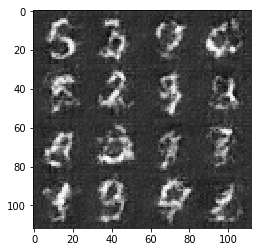

Epoch 1/2... Discriminator Loss: 0.3805... Generator Loss: 1.3531
Epoch 1/2... Discriminator Loss: 0.0790... Generator Loss: 4.2974
Epoch 1/2... Discriminator Loss: 0.1654... Generator Loss: 3.2796
Epoch 1/2... Discriminator Loss: 0.0423... Generator Loss: 5.1359
Epoch 1/2... Discriminator Loss: 0.1219... Generator Loss: 3.0532
Epoch 1/2... Discriminator Loss: 0.2616... Generator Loss: 1.7798
Epoch 1/2... Discriminator Loss: 1.8501... Generator Loss: 1.8937
Epoch 1/2... Discriminator Loss: 0.1049... Generator Loss: 3.4166
Epoch 1/2... Discriminator Loss: 0.0266... Generator Loss: 5.1593
Epoch 1/2... Discriminator Loss: 0.0253... Generator Loss: 5.5699


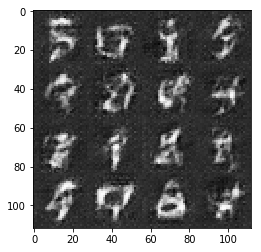

Epoch 1/2... Discriminator Loss: 0.9233... Generator Loss: 1.0128
Epoch 1/2... Discriminator Loss: 0.1035... Generator Loss: 3.7804
Epoch 1/2... Discriminator Loss: 0.0585... Generator Loss: 4.0475
Epoch 1/2... Discriminator Loss: 0.0287... Generator Loss: 4.9239
Epoch 1/2... Discriminator Loss: 0.4457... Generator Loss: 4.8044
Epoch 1/2... Discriminator Loss: 0.0822... Generator Loss: 3.3234
Epoch 1/2... Discriminator Loss: 0.1659... Generator Loss: 2.4468
Epoch 1/2... Discriminator Loss: 0.0913... Generator Loss: 5.1504
Epoch 1/2... Discriminator Loss: 0.0861... Generator Loss: 4.0266
Epoch 1/2... Discriminator Loss: 0.0329... Generator Loss: 4.2172


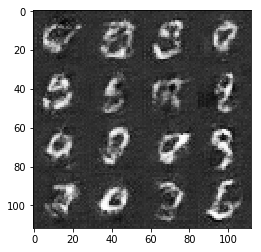

Epoch 1/2... Discriminator Loss: 0.2023... Generator Loss: 2.3170
Epoch 1/2... Discriminator Loss: 0.0500... Generator Loss: 4.0207
Epoch 1/2... Discriminator Loss: 0.0308... Generator Loss: 5.4000
Epoch 1/2... Discriminator Loss: 0.0468... Generator Loss: 6.9741
Epoch 1/2... Discriminator Loss: 0.0224... Generator Loss: 5.3549
Epoch 1/2... Discriminator Loss: 0.0866... Generator Loss: 7.2684
Epoch 1/2... Discriminator Loss: 0.6759... Generator Loss: 1.1233
Epoch 1/2... Discriminator Loss: 0.0261... Generator Loss: 4.9009
Epoch 1/2... Discriminator Loss: 17.5747... Generator Loss: 19.0058
Epoch 1/2... Discriminator Loss: 0.6889... Generator Loss: 1.9163


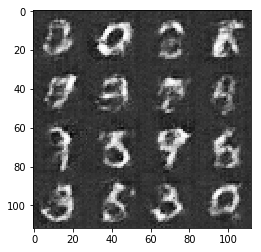

Epoch 1/2... Discriminator Loss: 1.7521... Generator Loss: 0.2553
Epoch 1/2... Discriminator Loss: 1.3381... Generator Loss: 0.4895
Epoch 1/2... Discriminator Loss: 1.3003... Generator Loss: 0.6386
Epoch 1/2... Discriminator Loss: 0.4857... Generator Loss: 1.3560
Epoch 1/2... Discriminator Loss: 0.6632... Generator Loss: 1.1391
Epoch 1/2... Discriminator Loss: 0.6645... Generator Loss: 0.9989
Epoch 1/2... Discriminator Loss: 0.3784... Generator Loss: 1.6273
Epoch 1/2... Discriminator Loss: 0.6404... Generator Loss: 1.0491
Epoch 1/2... Discriminator Loss: 0.6974... Generator Loss: 1.1306
Epoch 1/2... Discriminator Loss: 0.3375... Generator Loss: 1.7327


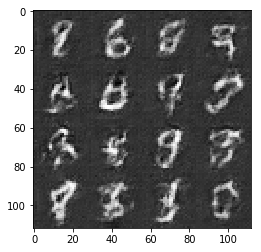

Epoch 1/2... Discriminator Loss: 0.3692... Generator Loss: 1.7307
Epoch 1/2... Discriminator Loss: 0.2705... Generator Loss: 1.8343
Epoch 1/2... Discriminator Loss: 0.1750... Generator Loss: 2.4188
Epoch 1/2... Discriminator Loss: 0.1990... Generator Loss: 2.3790
Epoch 1/2... Discriminator Loss: 0.3005... Generator Loss: 1.7867
Epoch 1/2... Discriminator Loss: 0.1645... Generator Loss: 2.4996
Epoch 1/2... Discriminator Loss: 0.0952... Generator Loss: 2.8749
Epoch 1/2... Discriminator Loss: 0.1122... Generator Loss: 3.1290
Epoch 1/2... Discriminator Loss: 0.1175... Generator Loss: 3.4248
Epoch 1/2... Discriminator Loss: 0.0859... Generator Loss: 3.2495


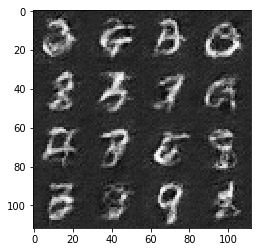

Epoch 1/2... Discriminator Loss: 0.1122... Generator Loss: 2.8796
Epoch 1/2... Discriminator Loss: 0.0797... Generator Loss: 3.3157
Epoch 1/2... Discriminator Loss: 0.0964... Generator Loss: 3.4598
Epoch 1/2... Discriminator Loss: 0.0633... Generator Loss: 3.8212
Epoch 1/2... Discriminator Loss: 0.4044... Generator Loss: 2.8699
Epoch 1/2... Discriminator Loss: 1.3236... Generator Loss: 0.5298
Epoch 1/2... Discriminator Loss: 1.8285... Generator Loss: 0.2617
Epoch 1/2... Discriminator Loss: 0.5168... Generator Loss: 1.5781
Epoch 1/2... Discriminator Loss: 0.7485... Generator Loss: 1.2075
Epoch 1/2... Discriminator Loss: 1.2879... Generator Loss: 0.5078


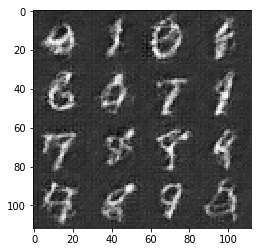

Epoch 1/2... Discriminator Loss: 0.4832... Generator Loss: 1.4337
Epoch 1/2... Discriminator Loss: 0.3023... Generator Loss: 1.8028
Epoch 1/2... Discriminator Loss: 0.6752... Generator Loss: 1.2113
Epoch 1/2... Discriminator Loss: 0.2589... Generator Loss: 1.9267
Epoch 1/2... Discriminator Loss: 0.3135... Generator Loss: 1.7868
Epoch 1/2... Discriminator Loss: 0.3112... Generator Loss: 1.8063
Epoch 1/2... Discriminator Loss: 0.1700... Generator Loss: 2.5281
Epoch 1/2... Discriminator Loss: 0.1116... Generator Loss: 3.1318
Epoch 1/2... Discriminator Loss: 0.2019... Generator Loss: 2.3842
Epoch 1/2... Discriminator Loss: 0.1613... Generator Loss: 2.5798


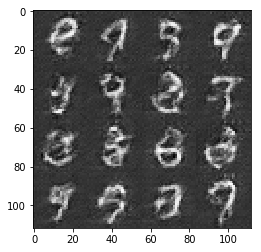

Epoch 1/2... Discriminator Loss: 0.1927... Generator Loss: 2.9995
Epoch 1/2... Discriminator Loss: 0.1282... Generator Loss: 2.7083
Epoch 1/2... Discriminator Loss: 0.0820... Generator Loss: 3.2460
Epoch 1/2... Discriminator Loss: 0.1424... Generator Loss: 2.5977
Epoch 1/2... Discriminator Loss: 0.0829... Generator Loss: 2.9534
Epoch 1/2... Discriminator Loss: 0.1645... Generator Loss: 2.9431
Epoch 1/2... Discriminator Loss: 0.1150... Generator Loss: 2.8762
Epoch 1/2... Discriminator Loss: 0.1377... Generator Loss: 2.4703
Epoch 1/2... Discriminator Loss: 0.1183... Generator Loss: 2.8581
Epoch 1/2... Discriminator Loss: 0.0993... Generator Loss: 3.6974


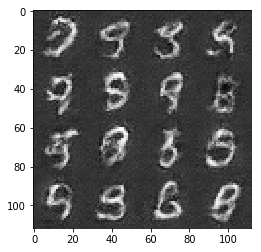

Epoch 1/2... Discriminator Loss: 0.0864... Generator Loss: 3.1081
Epoch 1/2... Discriminator Loss: 2.9783... Generator Loss: 0.0708
Epoch 1/2... Discriminator Loss: 2.6188... Generator Loss: 0.1340
Epoch 1/2... Discriminator Loss: 0.5075... Generator Loss: 3.5520
Epoch 1/2... Discriminator Loss: 1.1201... Generator Loss: 0.5207
Epoch 1/2... Discriminator Loss: 1.4627... Generator Loss: 0.4172
Epoch 1/2... Discriminator Loss: 1.0532... Generator Loss: 0.7249
Epoch 1/2... Discriminator Loss: 0.9361... Generator Loss: 0.7808
Epoch 1/2... Discriminator Loss: 1.0167... Generator Loss: 0.7194
Epoch 1/2... Discriminator Loss: 0.4644... Generator Loss: 3.1267


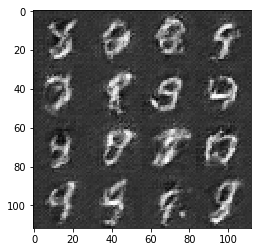

Epoch 1/2... Discriminator Loss: 0.3861... Generator Loss: 1.8479
Epoch 1/2... Discriminator Loss: 0.4626... Generator Loss: 1.5858
Epoch 1/2... Discriminator Loss: 0.3453... Generator Loss: 1.9428
Epoch 1/2... Discriminator Loss: 0.2236... Generator Loss: 2.2836
Epoch 1/2... Discriminator Loss: 0.3119... Generator Loss: 2.1022
Epoch 1/2... Discriminator Loss: 0.1970... Generator Loss: 2.1524
Epoch 1/2... Discriminator Loss: 0.1268... Generator Loss: 3.1432
Epoch 1/2... Discriminator Loss: 0.1157... Generator Loss: 3.4019
Epoch 1/2... Discriminator Loss: 0.4170... Generator Loss: 2.2563
Epoch 1/2... Discriminator Loss: 0.2153... Generator Loss: 2.1580


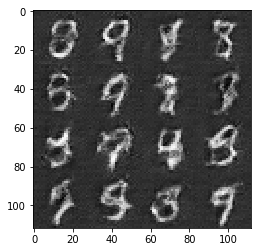

Epoch 1/2... Discriminator Loss: 0.3118... Generator Loss: 1.8418
Epoch 1/2... Discriminator Loss: 0.3814... Generator Loss: 1.8147
Epoch 1/2... Discriminator Loss: 0.1077... Generator Loss: 3.4374
Epoch 1/2... Discriminator Loss: 0.2248... Generator Loss: 2.3145
Epoch 1/2... Discriminator Loss: 0.1191... Generator Loss: 3.5584
Epoch 1/2... Discriminator Loss: 0.0803... Generator Loss: 3.3220
Epoch 1/2... Discriminator Loss: 0.0916... Generator Loss: 3.7924
Epoch 1/2... Discriminator Loss: 0.1100... Generator Loss: 3.1519
Epoch 1/2... Discriminator Loss: 0.1017... Generator Loss: 2.8641
Epoch 1/2... Discriminator Loss: 0.0820... Generator Loss: 3.4662


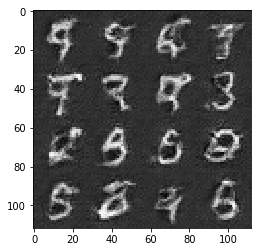

Epoch 1/2... Discriminator Loss: 0.0795... Generator Loss: 3.4819
Epoch 1/2... Discriminator Loss: 1.1442... Generator Loss: 0.6237
Epoch 1/2... Discriminator Loss: 0.4901... Generator Loss: 1.5597
Epoch 1/2... Discriminator Loss: 1.4717... Generator Loss: 0.4226
Epoch 1/2... Discriminator Loss: 0.5301... Generator Loss: 3.4368
Epoch 1/2... Discriminator Loss: 0.4942... Generator Loss: 1.6158
Epoch 1/2... Discriminator Loss: 0.8436... Generator Loss: 0.8912
Epoch 1/2... Discriminator Loss: 0.6975... Generator Loss: 1.0938
Epoch 1/2... Discriminator Loss: 0.9966... Generator Loss: 2.0035
Epoch 1/2... Discriminator Loss: 0.6741... Generator Loss: 1.3451


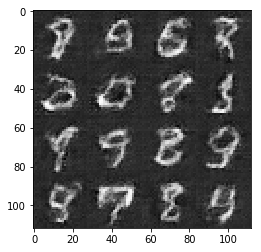

Epoch 1/2... Discriminator Loss: 0.3907... Generator Loss: 2.0548
Epoch 1/2... Discriminator Loss: 0.4070... Generator Loss: 2.2307
Epoch 1/2... Discriminator Loss: 0.8473... Generator Loss: 0.9854
Epoch 1/2... Discriminator Loss: 0.9161... Generator Loss: 1.0123
Epoch 1/2... Discriminator Loss: 0.5879... Generator Loss: 1.1592
Epoch 1/2... Discriminator Loss: 0.5896... Generator Loss: 1.3190
Epoch 1/2... Discriminator Loss: 0.5007... Generator Loss: 1.7338
Epoch 1/2... Discriminator Loss: 0.5203... Generator Loss: 1.3708
Epoch 1/2... Discriminator Loss: 0.5088... Generator Loss: 1.6738
Epoch 1/2... Discriminator Loss: 0.2117... Generator Loss: 2.4339


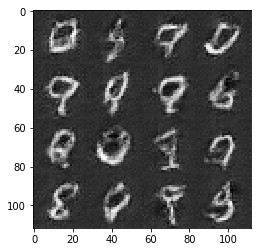

Epoch 1/2... Discriminator Loss: 0.1364... Generator Loss: 2.8210
Epoch 1/2... Discriminator Loss: 0.2838... Generator Loss: 2.3427
Epoch 1/2... Discriminator Loss: 0.2688... Generator Loss: 2.0902
Epoch 1/2... Discriminator Loss: 0.2046... Generator Loss: 2.3984
Epoch 1/2... Discriminator Loss: 0.2744... Generator Loss: 1.8643
Epoch 1/2... Discriminator Loss: 0.1300... Generator Loss: 2.7046
Epoch 1/2... Discriminator Loss: 0.1195... Generator Loss: 3.0423
Epoch 1/2... Discriminator Loss: 0.1133... Generator Loss: 2.6871
Epoch 1/2... Discriminator Loss: 0.0481... Generator Loss: 3.9393
Epoch 1/2... Discriminator Loss: 0.1619... Generator Loss: 3.0682


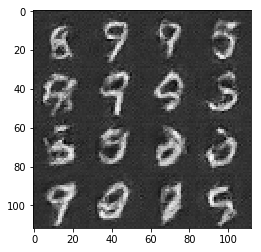

Epoch 1/2... Discriminator Loss: 0.0803... Generator Loss: 3.5596
Epoch 1/2... Discriminator Loss: 0.0939... Generator Loss: 3.2276
Epoch 1/2... Discriminator Loss: 0.0690... Generator Loss: 3.7403
Epoch 1/2... Discriminator Loss: 0.0606... Generator Loss: 4.0478
Epoch 1/2... Discriminator Loss: 0.0554... Generator Loss: 3.6470
Epoch 1/2... Discriminator Loss: 0.0763... Generator Loss: 3.4714
Epoch 1/2... Discriminator Loss: 0.0316... Generator Loss: 4.5831
Epoch 1/2... Discriminator Loss: 0.1441... Generator Loss: 3.1906
Epoch 1/2... Discriminator Loss: 0.0469... Generator Loss: 5.0119
Epoch 1/2... Discriminator Loss: 19.5075... Generator Loss: 25.4437


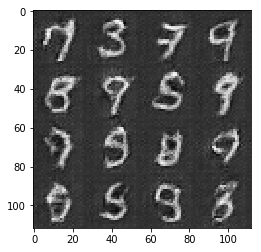

Epoch 1/2... Discriminator Loss: 2.5901... Generator Loss: 0.2747
Epoch 1/2... Discriminator Loss: 1.1565... Generator Loss: 0.6024
Epoch 1/2... Discriminator Loss: 0.9682... Generator Loss: 1.0552
Epoch 1/2... Discriminator Loss: 1.0269... Generator Loss: 1.1082
Epoch 1/2... Discriminator Loss: 0.9110... Generator Loss: 5.7770
Epoch 1/2... Discriminator Loss: 0.8072... Generator Loss: 0.8944
Epoch 1/2... Discriminator Loss: 0.7392... Generator Loss: 1.2402
Epoch 1/2... Discriminator Loss: 0.8807... Generator Loss: 1.0600
Epoch 1/2... Discriminator Loss: 0.4706... Generator Loss: 1.5043
Epoch 1/2... Discriminator Loss: 0.3552... Generator Loss: 2.6090


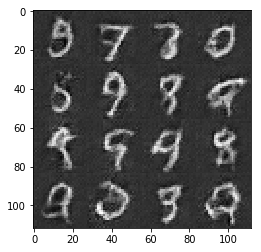

Epoch 1/2... Discriminator Loss: 0.9046... Generator Loss: 0.9466
Epoch 1/2... Discriminator Loss: 0.2888... Generator Loss: 2.4485
Epoch 1/2... Discriminator Loss: 0.9685... Generator Loss: 5.0448
Epoch 1/2... Discriminator Loss: 0.8731... Generator Loss: 1.5450
Epoch 1/2... Discriminator Loss: 1.1127... Generator Loss: 0.7297
Epoch 1/2... Discriminator Loss: 0.5294... Generator Loss: 1.7236
Epoch 1/2... Discriminator Loss: 0.2987... Generator Loss: 1.9130
Epoch 1/2... Discriminator Loss: 0.3387... Generator Loss: 1.8560
Epoch 1/2... Discriminator Loss: 0.5182... Generator Loss: 1.6754
Epoch 1/2... Discriminator Loss: 0.4055... Generator Loss: 1.7269


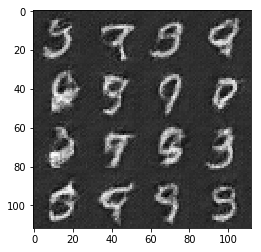

Epoch 1/2... Discriminator Loss: 0.4873... Generator Loss: 1.4665
Epoch 1/2... Discriminator Loss: 1.0022... Generator Loss: 3.9556
Epoch 1/2... Discriminator Loss: 1.2642... Generator Loss: 0.4258
Epoch 1/2... Discriminator Loss: 0.7694... Generator Loss: 0.8986
Epoch 1/2... Discriminator Loss: 0.8396... Generator Loss: 1.3069
Epoch 1/2... Discriminator Loss: 0.5775... Generator Loss: 1.3800
Epoch 1/2... Discriminator Loss: 0.6894... Generator Loss: 1.4309
Epoch 1/2... Discriminator Loss: 0.4439... Generator Loss: 1.8936
Epoch 1/2... Discriminator Loss: 1.0195... Generator Loss: 3.2512
Epoch 1/2... Discriminator Loss: 0.8601... Generator Loss: 0.8830


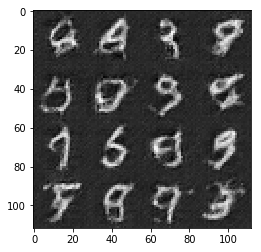

Epoch 1/2... Discriminator Loss: 0.4359... Generator Loss: 1.4619
Epoch 1/2... Discriminator Loss: 0.6615... Generator Loss: 1.1753
Epoch 1/2... Discriminator Loss: 0.3167... Generator Loss: 2.1564
Epoch 1/2... Discriminator Loss: 0.2272... Generator Loss: 2.2276
Epoch 1/2... Discriminator Loss: 0.3133... Generator Loss: 2.0967
Epoch 1/2... Discriminator Loss: 0.1697... Generator Loss: 2.5595
Epoch 1/2... Discriminator Loss: 0.4269... Generator Loss: 1.5279
Epoch 1/2... Discriminator Loss: 0.1699... Generator Loss: 2.4469
Epoch 1/2... Discriminator Loss: 0.2105... Generator Loss: 2.2028
Epoch 1/2... Discriminator Loss: 0.3534... Generator Loss: 2.0057


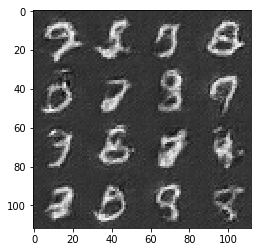

Epoch 1/2... Discriminator Loss: 0.5358... Generator Loss: 1.9769
Epoch 1/2... Discriminator Loss: 0.5811... Generator Loss: 1.8804
Epoch 1/2... Discriminator Loss: 0.2270... Generator Loss: 2.2670
Epoch 1/2... Discriminator Loss: 0.5490... Generator Loss: 2.2954
Epoch 1/2... Discriminator Loss: 3.6720... Generator Loss: 10.5610
Epoch 1/2... Discriminator Loss: 0.4850... Generator Loss: 2.3251
Epoch 1/2... Discriminator Loss: 1.9670... Generator Loss: 0.2042
Epoch 1/2... Discriminator Loss: 1.2875... Generator Loss: 0.6771
Epoch 1/2... Discriminator Loss: 0.5705... Generator Loss: 1.3291
Epoch 1/2... Discriminator Loss: 1.2034... Generator Loss: 0.6618


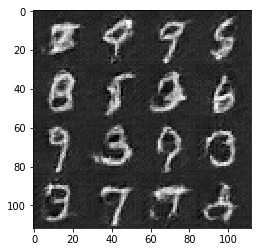

Epoch 1/2... Discriminator Loss: 0.5788... Generator Loss: 1.2041
Epoch 1/2... Discriminator Loss: 1.8347... Generator Loss: 5.0009
Epoch 1/2... Discriminator Loss: 0.6954... Generator Loss: 1.0801
Epoch 1/2... Discriminator Loss: 1.1828... Generator Loss: 0.4957
Epoch 1/2... Discriminator Loss: 0.7096... Generator Loss: 0.9033
Epoch 1/2... Discriminator Loss: 0.7545... Generator Loss: 1.4555
Epoch 1/2... Discriminator Loss: 0.7511... Generator Loss: 1.3311
Epoch 1/2... Discriminator Loss: 0.3841... Generator Loss: 2.4279
Epoch 1/2... Discriminator Loss: 0.4835... Generator Loss: 1.6717
Epoch 1/2... Discriminator Loss: 0.0735... Generator Loss: 3.5604


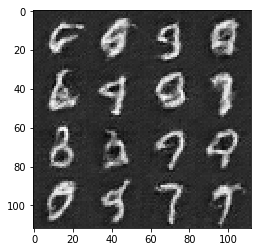

Epoch 2/2... Discriminator Loss: 0.3953... Generator Loss: 1.6972
Epoch 2/2... Discriminator Loss: 0.2784... Generator Loss: 1.7053
Epoch 2/2... Discriminator Loss: 0.6968... Generator Loss: 1.2725
Epoch 2/2... Discriminator Loss: 4.0622... Generator Loss: 8.9054
Epoch 2/2... Discriminator Loss: 1.4204... Generator Loss: 0.7312
Epoch 2/2... Discriminator Loss: 0.6660... Generator Loss: 2.9331
Epoch 2/2... Discriminator Loss: 1.3663... Generator Loss: 5.0905
Epoch 2/2... Discriminator Loss: 1.6757... Generator Loss: 0.5295
Epoch 2/2... Discriminator Loss: 0.5154... Generator Loss: 1.4864
Epoch 2/2... Discriminator Loss: 1.1598... Generator Loss: 0.5262


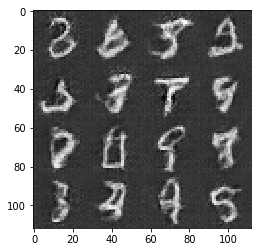

Epoch 2/2... Discriminator Loss: 0.3487... Generator Loss: 1.9506
Epoch 2/2... Discriminator Loss: 0.4191... Generator Loss: 1.6253
Epoch 2/2... Discriminator Loss: 0.9747... Generator Loss: 0.8830
Epoch 2/2... Discriminator Loss: 0.3817... Generator Loss: 1.9349
Epoch 2/2... Discriminator Loss: 0.3237... Generator Loss: 1.9429
Epoch 2/2... Discriminator Loss: 0.7022... Generator Loss: 1.1791
Epoch 2/2... Discriminator Loss: 0.3686... Generator Loss: 2.2795
Epoch 2/2... Discriminator Loss: 0.1877... Generator Loss: 2.2623
Epoch 2/2... Discriminator Loss: 0.3213... Generator Loss: 1.8776
Epoch 2/2... Discriminator Loss: 0.2319... Generator Loss: 2.0517


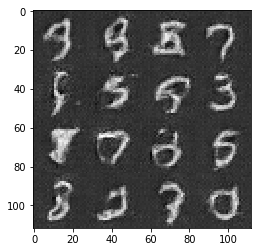

Epoch 2/2... Discriminator Loss: 0.1739... Generator Loss: 2.6382
Epoch 2/2... Discriminator Loss: 0.1343... Generator Loss: 2.7330
Epoch 2/2... Discriminator Loss: 0.2515... Generator Loss: 2.1889
Epoch 2/2... Discriminator Loss: 0.1188... Generator Loss: 2.7097
Epoch 2/2... Discriminator Loss: 0.3802... Generator Loss: 1.6936
Epoch 2/2... Discriminator Loss: 0.1107... Generator Loss: 3.2247
Epoch 2/2... Discriminator Loss: 0.1949... Generator Loss: 2.9035
Epoch 2/2... Discriminator Loss: 0.0713... Generator Loss: 3.7973
Epoch 2/2... Discriminator Loss: 0.1849... Generator Loss: 3.0677
Epoch 2/2... Discriminator Loss: 0.0538... Generator Loss: 4.0482


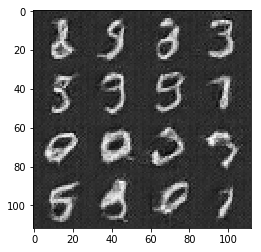

Epoch 2/2... Discriminator Loss: 0.2171... Generator Loss: 1.9763
Epoch 2/2... Discriminator Loss: 0.1254... Generator Loss: 2.9008
Epoch 2/2... Discriminator Loss: 0.0219... Generator Loss: 4.9151
Epoch 2/2... Discriminator Loss: 0.0714... Generator Loss: 3.5399
Epoch 2/2... Discriminator Loss: 0.2077... Generator Loss: 2.1952
Epoch 2/2... Discriminator Loss: 0.0586... Generator Loss: 3.4506
Epoch 2/2... Discriminator Loss: 0.0338... Generator Loss: 4.4174
Epoch 2/2... Discriminator Loss: 0.0243... Generator Loss: 4.8882
Epoch 2/2... Discriminator Loss: 0.2391... Generator Loss: 2.1072
Epoch 2/2... Discriminator Loss: 0.3779... Generator Loss: 2.1005


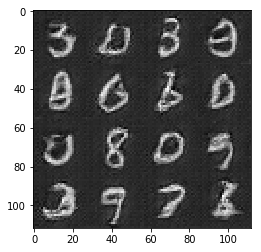

Epoch 2/2... Discriminator Loss: 0.0243... Generator Loss: 5.1784
Epoch 2/2... Discriminator Loss: 0.0126... Generator Loss: 5.3134
Epoch 2/2... Discriminator Loss: 0.1059... Generator Loss: 3.1656
Epoch 2/2... Discriminator Loss: 0.0782... Generator Loss: 3.1919
Epoch 2/2... Discriminator Loss: 0.0925... Generator Loss: 3.3630
Epoch 2/2... Discriminator Loss: 0.0222... Generator Loss: 4.7720
Epoch 2/2... Discriminator Loss: 0.1219... Generator Loss: 3.7133
Epoch 2/2... Discriminator Loss: 0.0309... Generator Loss: 4.2493
Epoch 2/2... Discriminator Loss: 0.0258... Generator Loss: 4.7247
Epoch 2/2... Discriminator Loss: 0.0315... Generator Loss: 5.0782


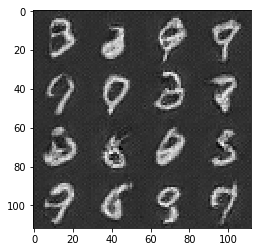

Epoch 2/2... Discriminator Loss: 0.0332... Generator Loss: 4.4648
Epoch 2/2... Discriminator Loss: 0.0334... Generator Loss: 4.3825
Epoch 2/2... Discriminator Loss: 2.4088... Generator Loss: 9.8179
Epoch 2/2... Discriminator Loss: 0.2091... Generator Loss: 2.5874
Epoch 2/2... Discriminator Loss: 1.2411... Generator Loss: 0.4705
Epoch 2/2... Discriminator Loss: 0.2290... Generator Loss: 2.4300
Epoch 2/2... Discriminator Loss: 1.2551... Generator Loss: 0.7284
Epoch 2/2... Discriminator Loss: 0.4165... Generator Loss: 1.9811
Epoch 2/2... Discriminator Loss: 0.5601... Generator Loss: 2.5108
Epoch 2/2... Discriminator Loss: 0.3189... Generator Loss: 2.7568


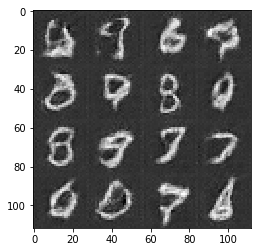

Epoch 2/2... Discriminator Loss: 1.1039... Generator Loss: 0.6644
Epoch 2/2... Discriminator Loss: 1.4092... Generator Loss: 7.9973
Epoch 2/2... Discriminator Loss: 0.4227... Generator Loss: 3.3164
Epoch 2/2... Discriminator Loss: 0.3240... Generator Loss: 2.2024
Epoch 2/2... Discriminator Loss: 0.6547... Generator Loss: 1.5751
Epoch 2/2... Discriminator Loss: 0.9615... Generator Loss: 0.7312
Epoch 2/2... Discriminator Loss: 0.6771... Generator Loss: 1.1987
Epoch 2/2... Discriminator Loss: 0.5532... Generator Loss: 1.3701
Epoch 2/2... Discriminator Loss: 0.2084... Generator Loss: 2.5585
Epoch 2/2... Discriminator Loss: 1.5520... Generator Loss: 0.4627


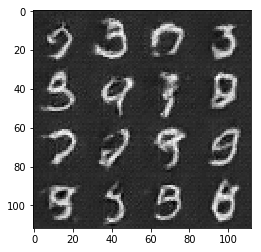

Epoch 2/2... Discriminator Loss: 0.5038... Generator Loss: 1.4909
Epoch 2/2... Discriminator Loss: 0.6967... Generator Loss: 1.4862
Epoch 2/2... Discriminator Loss: 0.2045... Generator Loss: 2.4712
Epoch 2/2... Discriminator Loss: 0.4655... Generator Loss: 2.1096
Epoch 2/2... Discriminator Loss: 0.5428... Generator Loss: 1.5164
Epoch 2/2... Discriminator Loss: 0.0735... Generator Loss: 3.8251
Epoch 2/2... Discriminator Loss: 0.7518... Generator Loss: 1.2360
Epoch 2/2... Discriminator Loss: 0.2600... Generator Loss: 2.1072
Epoch 2/2... Discriminator Loss: 0.1656... Generator Loss: 2.6299
Epoch 2/2... Discriminator Loss: 0.2416... Generator Loss: 2.5916


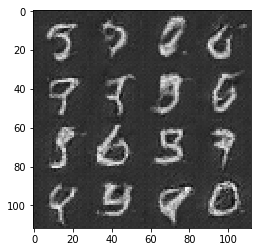

Epoch 2/2... Discriminator Loss: 0.2856... Generator Loss: 2.2765
Epoch 2/2... Discriminator Loss: 0.1498... Generator Loss: 2.4600
Epoch 2/2... Discriminator Loss: 0.3003... Generator Loss: 2.3808
Epoch 2/2... Discriminator Loss: 0.1953... Generator Loss: 2.4699
Epoch 2/2... Discriminator Loss: 0.2599... Generator Loss: 2.2766
Epoch 2/2... Discriminator Loss: 0.0682... Generator Loss: 3.9716
Epoch 2/2... Discriminator Loss: 0.1349... Generator Loss: 3.4000
Epoch 2/2... Discriminator Loss: 0.0852... Generator Loss: 3.0762
Epoch 2/2... Discriminator Loss: 0.0593... Generator Loss: 4.0338
Epoch 2/2... Discriminator Loss: 0.1464... Generator Loss: 2.7623


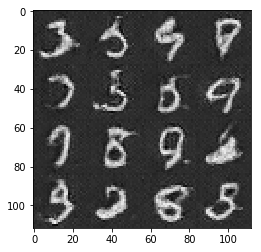

Epoch 2/2... Discriminator Loss: 0.0790... Generator Loss: 3.5012
Epoch 2/2... Discriminator Loss: 0.0069... Generator Loss: 7.1015
Epoch 2/2... Discriminator Loss: 0.0805... Generator Loss: 3.2875
Epoch 2/2... Discriminator Loss: 0.2228... Generator Loss: 2.4733
Epoch 2/2... Discriminator Loss: 0.1926... Generator Loss: 2.5455
Epoch 2/2... Discriminator Loss: 0.0490... Generator Loss: 4.5474
Epoch 2/2... Discriminator Loss: 0.0069... Generator Loss: 6.6281
Epoch 2/2... Discriminator Loss: 0.1020... Generator Loss: 2.8947
Epoch 2/2... Discriminator Loss: 0.1536... Generator Loss: 2.5375
Epoch 2/2... Discriminator Loss: 0.0849... Generator Loss: 4.1209


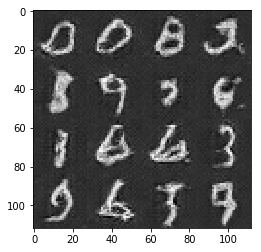

Epoch 2/2... Discriminator Loss: 0.0117... Generator Loss: 5.6154
Epoch 2/2... Discriminator Loss: 0.1540... Generator Loss: 2.6567
Epoch 2/2... Discriminator Loss: 0.0772... Generator Loss: 3.6039
Epoch 2/2... Discriminator Loss: 0.1235... Generator Loss: 2.9289
Epoch 2/2... Discriminator Loss: 0.1571... Generator Loss: 2.6769
Epoch 2/2... Discriminator Loss: 0.1481... Generator Loss: 3.2489
Epoch 2/2... Discriminator Loss: 0.1470... Generator Loss: 2.7758
Epoch 2/2... Discriminator Loss: 0.0841... Generator Loss: 3.9306
Epoch 2/2... Discriminator Loss: 0.1282... Generator Loss: 2.5902
Epoch 2/2... Discriminator Loss: 0.0158... Generator Loss: 5.2962


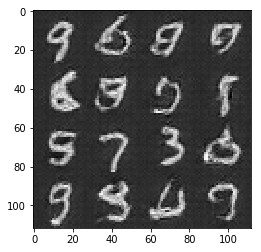

Epoch 2/2... Discriminator Loss: 0.0632... Generator Loss: 3.8820
Epoch 2/2... Discriminator Loss: 0.0560... Generator Loss: 3.5419
Epoch 2/2... Discriminator Loss: 4.0480... Generator Loss: 0.0492
Epoch 2/2... Discriminator Loss: 0.8057... Generator Loss: 1.1000
Epoch 2/2... Discriminator Loss: 2.7565... Generator Loss: 0.1317
Epoch 2/2... Discriminator Loss: 0.4264... Generator Loss: 4.2754
Epoch 2/2... Discriminator Loss: 0.5484... Generator Loss: 1.2663
Epoch 2/2... Discriminator Loss: 0.5115... Generator Loss: 1.3968
Epoch 2/2... Discriminator Loss: 2.9509... Generator Loss: 0.2406
Epoch 2/2... Discriminator Loss: 0.2698... Generator Loss: 2.3317


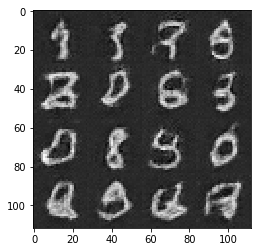

Epoch 2/2... Discriminator Loss: 0.4486... Generator Loss: 1.5664
Epoch 2/2... Discriminator Loss: 0.8636... Generator Loss: 1.0039
Epoch 2/2... Discriminator Loss: 1.8132... Generator Loss: 0.3657
Epoch 2/2... Discriminator Loss: 0.6022... Generator Loss: 1.3325
Epoch 2/2... Discriminator Loss: 0.2680... Generator Loss: 3.1258
Epoch 2/2... Discriminator Loss: 0.7024... Generator Loss: 1.2629
Epoch 2/2... Discriminator Loss: 0.4491... Generator Loss: 1.6095
Epoch 2/2... Discriminator Loss: 0.5486... Generator Loss: 1.4458
Epoch 2/2... Discriminator Loss: 0.2511... Generator Loss: 2.0386
Epoch 2/2... Discriminator Loss: 0.4934... Generator Loss: 1.9937


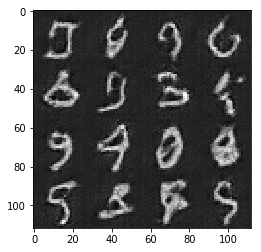

Epoch 2/2... Discriminator Loss: 0.4890... Generator Loss: 4.2526
Epoch 2/2... Discriminator Loss: 2.1679... Generator Loss: 0.3486
Epoch 2/2... Discriminator Loss: 1.2329... Generator Loss: 0.8202
Epoch 2/2... Discriminator Loss: 1.3152... Generator Loss: 5.2401
Epoch 2/2... Discriminator Loss: 1.8168... Generator Loss: 0.2872
Epoch 2/2... Discriminator Loss: 0.3115... Generator Loss: 1.6126
Epoch 2/2... Discriminator Loss: 1.6326... Generator Loss: 0.2974
Epoch 2/2... Discriminator Loss: 0.6962... Generator Loss: 1.2998
Epoch 2/2... Discriminator Loss: 0.2934... Generator Loss: 2.2798
Epoch 2/2... Discriminator Loss: 0.4184... Generator Loss: 1.4461


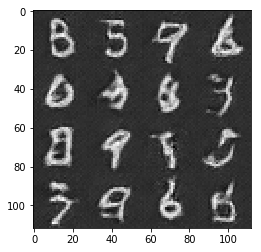

Epoch 2/2... Discriminator Loss: 0.5849... Generator Loss: 1.5607
Epoch 2/2... Discriminator Loss: 0.4756... Generator Loss: 1.4357
Epoch 2/2... Discriminator Loss: 0.3220... Generator Loss: 2.3437
Epoch 2/2... Discriminator Loss: 0.4649... Generator Loss: 1.6530
Epoch 2/2... Discriminator Loss: 0.2210... Generator Loss: 2.2680
Epoch 2/2... Discriminator Loss: 0.5558... Generator Loss: 1.3184
Epoch 2/2... Discriminator Loss: 0.1713... Generator Loss: 2.4084
Epoch 2/2... Discriminator Loss: 0.3012... Generator Loss: 2.3419
Epoch 2/2... Discriminator Loss: 0.2879... Generator Loss: 2.0446
Epoch 2/2... Discriminator Loss: 0.2897... Generator Loss: 1.9634


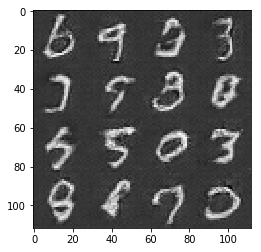

Epoch 2/2... Discriminator Loss: 0.0207... Generator Loss: 5.2471
Epoch 2/2... Discriminator Loss: 0.1501... Generator Loss: 2.5502
Epoch 2/2... Discriminator Loss: 0.3968... Generator Loss: 1.7102
Epoch 2/2... Discriminator Loss: 0.0998... Generator Loss: 2.8628
Epoch 2/2... Discriminator Loss: 0.1959... Generator Loss: 2.1586
Epoch 2/2... Discriminator Loss: 0.2630... Generator Loss: 2.2898
Epoch 2/2... Discriminator Loss: 0.1456... Generator Loss: 2.7936
Epoch 2/2... Discriminator Loss: 0.4116... Generator Loss: 1.7000
Epoch 2/2... Discriminator Loss: 0.0952... Generator Loss: 3.3605
Epoch 2/2... Discriminator Loss: 0.0154... Generator Loss: 5.6284


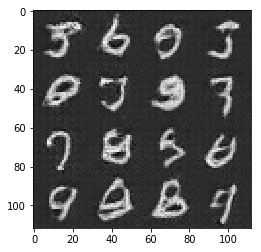

Epoch 2/2... Discriminator Loss: 0.0890... Generator Loss: 3.8504
Epoch 2/2... Discriminator Loss: 0.2113... Generator Loss: 2.7901
Epoch 2/2... Discriminator Loss: 0.1362... Generator Loss: 3.3429
Epoch 2/2... Discriminator Loss: 0.0132... Generator Loss: 6.0549
Epoch 2/2... Discriminator Loss: 0.2624... Generator Loss: 1.7765
Epoch 2/2... Discriminator Loss: 0.0239... Generator Loss: 5.4380
Epoch 2/2... Discriminator Loss: 0.0707... Generator Loss: 3.7002
Epoch 2/2... Discriminator Loss: 0.0565... Generator Loss: 4.1411
Epoch 2/2... Discriminator Loss: 0.0740... Generator Loss: 3.4730
Epoch 2/2... Discriminator Loss: 0.0477... Generator Loss: 6.1630


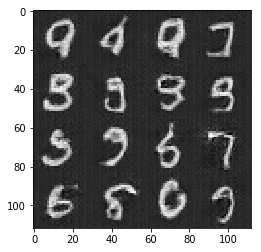

Epoch 2/2... Discriminator Loss: 0.0169... Generator Loss: 5.3811
Epoch 2/2... Discriminator Loss: 0.0225... Generator Loss: 6.5506
Epoch 2/2... Discriminator Loss: 0.0120... Generator Loss: 6.3219
Epoch 2/2... Discriminator Loss: 0.0874... Generator Loss: 3.3741
Epoch 2/2... Discriminator Loss: 0.0853... Generator Loss: 3.4444
Epoch 2/2... Discriminator Loss: 0.0116... Generator Loss: 5.9610
Epoch 2/2... Discriminator Loss: 0.2150... Generator Loss: 2.2607
Epoch 2/2... Discriminator Loss: 0.0497... Generator Loss: 3.9033
Epoch 2/2... Discriminator Loss: 0.1386... Generator Loss: 2.6949
Epoch 2/2... Discriminator Loss: 0.0741... Generator Loss: 4.0320


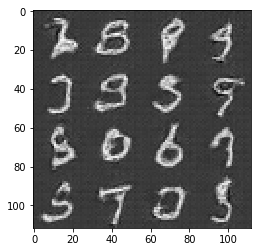

Epoch 2/2... Discriminator Loss: 0.0074... Generator Loss: 6.1102
Epoch 2/2... Discriminator Loss: 3.0630... Generator Loss: 0.0901
Epoch 2/2... Discriminator Loss: 0.6233... Generator Loss: 2.0810
Epoch 2/2... Discriminator Loss: 0.6998... Generator Loss: 4.4352
Epoch 2/2... Discriminator Loss: 0.9155... Generator Loss: 5.4297
Epoch 2/2... Discriminator Loss: 0.4778... Generator Loss: 1.8426
Epoch 2/2... Discriminator Loss: 0.2138... Generator Loss: 2.5402
Epoch 2/2... Discriminator Loss: 0.7992... Generator Loss: 0.9718
Epoch 2/2... Discriminator Loss: 1.1382... Generator Loss: 0.6163
Epoch 2/2... Discriminator Loss: 0.2487... Generator Loss: 3.3634


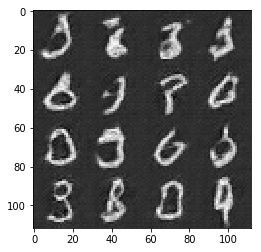

Epoch 2/2... Discriminator Loss: 0.5765... Generator Loss: 1.1172
Epoch 2/2... Discriminator Loss: 0.3652... Generator Loss: 3.0609
Epoch 2/2... Discriminator Loss: 0.3573... Generator Loss: 2.3430
Epoch 2/2... Discriminator Loss: 0.5733... Generator Loss: 1.6518
Epoch 2/2... Discriminator Loss: 0.5158... Generator Loss: 1.2745
Epoch 2/2... Discriminator Loss: 0.5273... Generator Loss: 3.6825
Epoch 2/2... Discriminator Loss: 0.3587... Generator Loss: 1.7114
Epoch 2/2... Discriminator Loss: 0.5811... Generator Loss: 1.4589
Epoch 2/2... Discriminator Loss: 0.8110... Generator Loss: 5.1141
Epoch 2/2... Discriminator Loss: 1.7736... Generator Loss: 0.2807


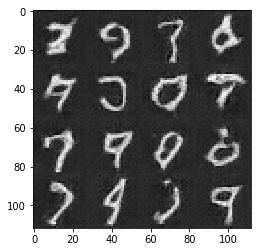

Epoch 2/2... Discriminator Loss: 0.5829... Generator Loss: 1.9682
Epoch 2/2... Discriminator Loss: 0.2403... Generator Loss: 2.2603
Epoch 2/2... Discriminator Loss: 1.7198... Generator Loss: 0.4868
Epoch 2/2... Discriminator Loss: 0.6374... Generator Loss: 1.3853
Epoch 2/2... Discriminator Loss: 0.1924... Generator Loss: 2.5552
Epoch 2/2... Discriminator Loss: 0.2329... Generator Loss: 2.1775
Epoch 2/2... Discriminator Loss: 0.2837... Generator Loss: 2.2054
Epoch 2/2... Discriminator Loss: 0.2882... Generator Loss: 1.8835
Epoch 2/2... Discriminator Loss: 0.2776... Generator Loss: 1.8661
Epoch 2/2... Discriminator Loss: 0.2517... Generator Loss: 2.2561


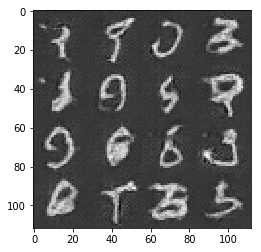

Epoch 2/2... Discriminator Loss: 0.3630... Generator Loss: 1.5620
Epoch 2/2... Discriminator Loss: 0.0607... Generator Loss: 4.2593
Epoch 2/2... Discriminator Loss: 0.1779... Generator Loss: 2.6421
Epoch 2/2... Discriminator Loss: 0.3241... Generator Loss: 2.0008
Epoch 2/2... Discriminator Loss: 0.3759... Generator Loss: 2.1627
Epoch 2/2... Discriminator Loss: 0.7997... Generator Loss: 1.2201
Epoch 2/2... Discriminator Loss: 0.3212... Generator Loss: 1.9160
Epoch 2/2... Discriminator Loss: 0.3608... Generator Loss: 1.5459
Epoch 2/2... Discriminator Loss: 0.3537... Generator Loss: 5.5965
Epoch 2/2... Discriminator Loss: 0.8765... Generator Loss: 3.1870


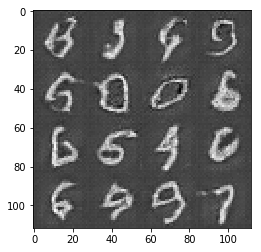

Epoch 2/2... Discriminator Loss: 1.1034... Generator Loss: 0.5403
Epoch 2/2... Discriminator Loss: 0.5327... Generator Loss: 1.4221
Epoch 2/2... Discriminator Loss: 0.4765... Generator Loss: 4.8674
Epoch 2/2... Discriminator Loss: 0.3292... Generator Loss: 2.6452
Epoch 2/2... Discriminator Loss: 0.4570... Generator Loss: 2.3369
Epoch 2/2... Discriminator Loss: 0.1695... Generator Loss: 2.9223
Epoch 2/2... Discriminator Loss: 0.3761... Generator Loss: 1.8065
Epoch 2/2... Discriminator Loss: 0.1744... Generator Loss: 2.9378
Epoch 2/2... Discriminator Loss: 0.2335... Generator Loss: 2.6653
Epoch 2/2... Discriminator Loss: 0.5396... Generator Loss: 2.6737


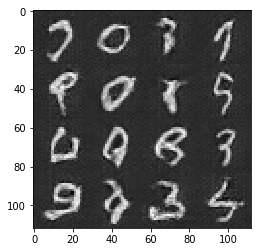

Epoch 2/2... Discriminator Loss: 0.3682... Generator Loss: 2.1508
Epoch 2/2... Discriminator Loss: 0.6515... Generator Loss: 1.2178
Epoch 2/2... Discriminator Loss: 0.7600... Generator Loss: 1.5613
Epoch 2/2... Discriminator Loss: 0.3363... Generator Loss: 1.7895
Epoch 2/2... Discriminator Loss: 0.1742... Generator Loss: 2.8517
Epoch 2/2... Discriminator Loss: 0.2456... Generator Loss: 2.0541
Epoch 2/2... Discriminator Loss: 0.4466... Generator Loss: 1.5903
Epoch 2/2... Discriminator Loss: 0.0600... Generator Loss: 3.9499
Epoch 2/2... Discriminator Loss: 0.2531... Generator Loss: 2.3339
Epoch 2/2... Discriminator Loss: 0.2074... Generator Loss: 2.3125


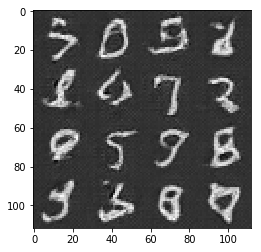

Epoch 2/2... Discriminator Loss: 0.1554... Generator Loss: 2.5075
Epoch 2/2... Discriminator Loss: 0.0564... Generator Loss: 4.4239
Epoch 2/2... Discriminator Loss: 0.0725... Generator Loss: 3.8837
Epoch 2/2... Discriminator Loss: 0.1190... Generator Loss: 3.0888
Epoch 2/2... Discriminator Loss: 0.4372... Generator Loss: 1.5999
Epoch 2/2... Discriminator Loss: 0.1927... Generator Loss: 2.4359
Epoch 2/2... Discriminator Loss: 0.3882... Generator Loss: 1.7735
Epoch 2/2... Discriminator Loss: 0.0196... Generator Loss: 5.8375
Epoch 2/2... Discriminator Loss: 0.1816... Generator Loss: 2.4440
Epoch 2/2... Discriminator Loss: 0.7820... Generator Loss: 0.8508


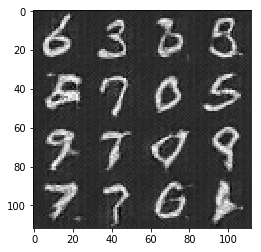

Epoch 2/2... Discriminator Loss: 0.0458... Generator Loss: 3.9754
Epoch 2/2... Discriminator Loss: 0.5231... Generator Loss: 1.1246
Epoch 2/2... Discriminator Loss: 1.3187... Generator Loss: 0.7642
Epoch 2/2... Discriminator Loss: 1.2963... Generator Loss: 0.6340
Epoch 2/2... Discriminator Loss: 0.3315... Generator Loss: 3.5530
Epoch 2/2... Discriminator Loss: 0.8568... Generator Loss: 1.3292
Epoch 2/2... Discriminator Loss: 0.7051... Generator Loss: 0.9757
Epoch 2/2... Discriminator Loss: 0.3869... Generator Loss: 1.7610
Epoch 2/2... Discriminator Loss: 0.1743... Generator Loss: 3.2360
Epoch 2/2... Discriminator Loss: 0.3783... Generator Loss: 2.0631


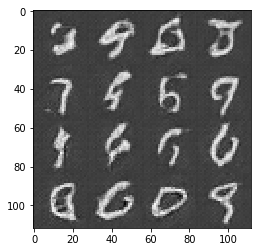

Epoch 2/2... Discriminator Loss: 0.6122... Generator Loss: 1.7710
Epoch 2/2... Discriminator Loss: 0.3539... Generator Loss: 2.4490
Epoch 2/2... Discriminator Loss: 0.1206... Generator Loss: 2.9004
Epoch 2/2... Discriminator Loss: 0.4924... Generator Loss: 1.6359
Epoch 2/2... Discriminator Loss: 0.1894... Generator Loss: 2.5048
Epoch 2/2... Discriminator Loss: 2.6362... Generator Loss: 6.9735
Epoch 2/2... Discriminator Loss: 0.6761... Generator Loss: 0.8916
Epoch 2/2... Discriminator Loss: 0.1714... Generator Loss: 2.8358
Epoch 2/2... Discriminator Loss: 0.3263... Generator Loss: 2.2926
Epoch 2/2... Discriminator Loss: 1.0170... Generator Loss: 0.8443


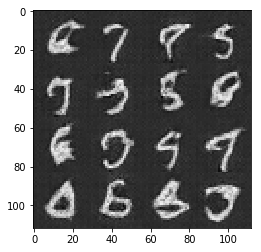

Epoch 2/2... Discriminator Loss: 1.1131... Generator Loss: 1.4127
Epoch 2/2... Discriminator Loss: 2.2152... Generator Loss: 0.4527
Epoch 2/2... Discriminator Loss: 1.1666... Generator Loss: 0.6357
Epoch 2/2... Discriminator Loss: 1.0245... Generator Loss: 3.8404
Epoch 2/2... Discriminator Loss: 0.7336... Generator Loss: 1.0184
Epoch 2/2... Discriminator Loss: 0.5003... Generator Loss: 1.4667
Epoch 2/2... Discriminator Loss: 0.7005... Generator Loss: 1.0794
Epoch 2/2... Discriminator Loss: 0.8167... Generator Loss: 1.0678
Epoch 2/2... Discriminator Loss: 0.7482... Generator Loss: 1.1512
Epoch 2/2... Discriminator Loss: 1.5254... Generator Loss: 0.3398


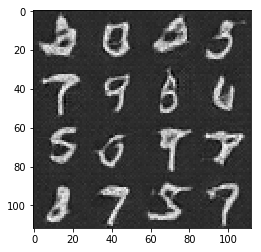

Epoch 2/2... Discriminator Loss: 1.3479... Generator Loss: 0.5762
Epoch 2/2... Discriminator Loss: 0.2927... Generator Loss: 2.3752
Epoch 2/2... Discriminator Loss: 0.5170... Generator Loss: 1.5486
Epoch 2/2... Discriminator Loss: 0.3078... Generator Loss: 2.0108
Epoch 2/2... Discriminator Loss: 0.2900... Generator Loss: 1.9549
Epoch 2/2... Discriminator Loss: 0.6569... Generator Loss: 1.2901
Epoch 2/2... Discriminator Loss: 0.7456... Generator Loss: 1.0315
Epoch 2/2... Discriminator Loss: 0.7973... Generator Loss: 0.9235
Epoch 2/2... Discriminator Loss: 0.0361... Generator Loss: 4.9246
Epoch 2/2... Discriminator Loss: 0.0902... Generator Loss: 3.9853


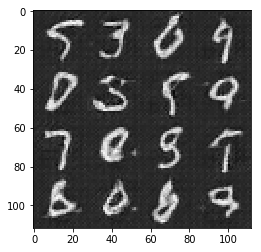

Epoch 2/2... Discriminator Loss: 0.3055... Generator Loss: 2.4929
Epoch 2/2... Discriminator Loss: 0.3834... Generator Loss: 1.8371
Epoch 2/2... Discriminator Loss: 1.0330... Generator Loss: 0.8093
Epoch 2/2... Discriminator Loss: 0.4198... Generator Loss: 2.1854
Epoch 2/2... Discriminator Loss: 0.1177... Generator Loss: 3.3179
Epoch 2/2... Discriminator Loss: 0.3859... Generator Loss: 2.4631
Epoch 2/2... Discriminator Loss: 0.0228... Generator Loss: 5.3279
Epoch 2/2... Discriminator Loss: 0.2628... Generator Loss: 2.3598
Epoch 2/2... Discriminator Loss: 0.1491... Generator Loss: 2.8696
Epoch 2/2... Discriminator Loss: 0.1073... Generator Loss: 3.4642


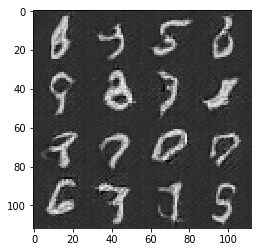

In [ ]:
batch_size = 20
z_dim = 100
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.2264... Generator Loss: 0.1543
Epoch 1/1... Discriminator Loss: 6.4379... Generator Loss: 14.5800
Epoch 1/1... Discriminator Loss: 2.3197... Generator Loss: 9.1790
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 5.8331
Epoch 1/1... Discriminator Loss: 0.3120... Generator Loss: 3.9778
Epoch 1/1... Discriminator Loss: 0.6942... Generator Loss: 0.9887
Epoch 1/1... Discriminator Loss: 0.5508... Generator Loss: 1.4351
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.4854
Epoch 1/1... Discriminator Loss: 0.9208... Generator Loss: 2.8193
Epoch 1/1... Discriminator Loss: 0.2982... Generator Loss: 2.2753


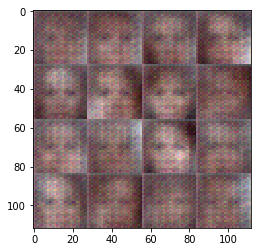

Epoch 1/1... Discriminator Loss: 0.4372... Generator Loss: 6.3751
Epoch 1/1... Discriminator Loss: 0.2368... Generator Loss: 8.9837
Epoch 1/1... Discriminator Loss: 1.8713... Generator Loss: 0.2951
Epoch 1/1... Discriminator Loss: 0.2894... Generator Loss: 2.1225
Epoch 1/1... Discriminator Loss: 0.7687... Generator Loss: 10.5698
Epoch 1/1... Discriminator Loss: 0.2056... Generator Loss: 6.1888
Epoch 1/1... Discriminator Loss: 0.1177... Generator Loss: 9.7666
Epoch 1/1... Discriminator Loss: 0.0606... Generator Loss: 5.4343
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 1.8826
Epoch 1/1... Discriminator Loss: 0.0773... Generator Loss: 4.6487


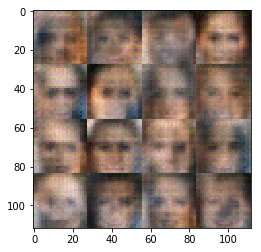

Epoch 1/1... Discriminator Loss: 0.2295... Generator Loss: 3.3229
Epoch 1/1... Discriminator Loss: 0.0348... Generator Loss: 7.8870
Epoch 1/1... Discriminator Loss: 0.0391... Generator Loss: 11.4281
Epoch 1/1... Discriminator Loss: 3.9023... Generator Loss: 4.6714
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.4361
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.4695
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 0.6274... Generator Loss: 9.0501
Epoch 1/1... Discriminator Loss: 0.0714... Generator Loss: 8.3073
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 9.0071


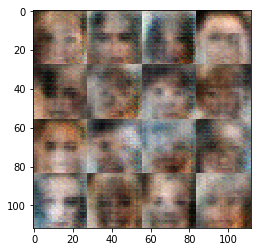

Epoch 1/1... Discriminator Loss: 0.3454... Generator Loss: 2.6658
Epoch 1/1... Discriminator Loss: 0.0663... Generator Loss: 12.2539
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 3.3212
Epoch 1/1... Discriminator Loss: 0.0760... Generator Loss: 7.1303
Epoch 1/1... Discriminator Loss: 0.2018... Generator Loss: 2.8392
Epoch 1/1... Discriminator Loss: 0.1788... Generator Loss: 4.2205
Epoch 1/1... Discriminator Loss: 0.4230... Generator Loss: 13.9444
Epoch 1/1... Discriminator Loss: 0.4419... Generator Loss: 4.4709
Epoch 1/1... Discriminator Loss: 0.0700... Generator Loss: 14.5543
Epoch 1/1... Discriminator Loss: 0.0588... Generator Loss: 9.8969


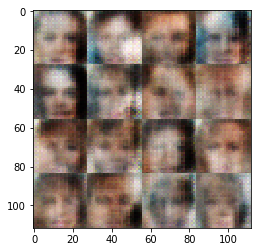

Epoch 1/1... Discriminator Loss: 0.0647... Generator Loss: 8.2852
Epoch 1/1... Discriminator Loss: 3.4741... Generator Loss: 4.3059
Epoch 1/1... Discriminator Loss: 2.5336... Generator Loss: 3.8292
Epoch 1/1... Discriminator Loss: 0.7530... Generator Loss: 1.3912
Epoch 1/1... Discriminator Loss: 0.1474... Generator Loss: 6.2152
Epoch 1/1... Discriminator Loss: 0.4561... Generator Loss: 1.6527
Epoch 1/1... Discriminator Loss: 0.4447... Generator Loss: 11.3477
Epoch 1/1... Discriminator Loss: 0.5655... Generator Loss: 10.1169
Epoch 1/1... Discriminator Loss: 0.0956... Generator Loss: 10.3514
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 1.1847


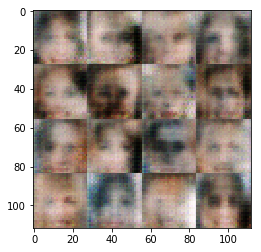

Epoch 1/1... Discriminator Loss: 0.2807... Generator Loss: 2.7612
Epoch 1/1... Discriminator Loss: 0.0453... Generator Loss: 10.2753
Epoch 1/1... Discriminator Loss: 0.1380... Generator Loss: 4.2315
Epoch 1/1... Discriminator Loss: 0.0312... Generator Loss: 9.0290
Epoch 1/1... Discriminator Loss: 0.1290... Generator Loss: 3.9212
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 12.3158
Epoch 1/1... Discriminator Loss: 0.0354... Generator Loss: 10.5176
Epoch 1/1... Discriminator Loss: 0.1558... Generator Loss: 11.3239
Epoch 1/1... Discriminator Loss: 0.3978... Generator Loss: 12.6049
Epoch 1/1... Discriminator Loss: 0.0447... Generator Loss: 12.2219


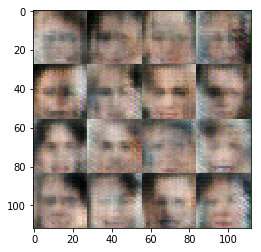

Epoch 1/1... Discriminator Loss: 0.0288... Generator Loss: 13.1657
Epoch 1/1... Discriminator Loss: 0.0245... Generator Loss: 12.5410
Epoch 1/1... Discriminator Loss: 0.0278... Generator Loss: 7.8120
Epoch 1/1... Discriminator Loss: 0.0288... Generator Loss: 10.6835
Epoch 1/1... Discriminator Loss: 0.4221... Generator Loss: 6.2428
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 4.1709
Epoch 1/1... Discriminator Loss: 0.4020... Generator Loss: 3.1920
Epoch 1/1... Discriminator Loss: 0.8993... Generator Loss: 1.6445
Epoch 1/1... Discriminator Loss: 0.0668... Generator Loss: 7.6173
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 0.9956


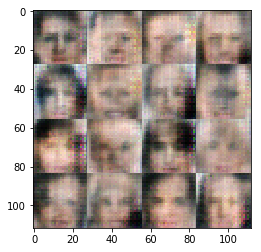

Epoch 1/1... Discriminator Loss: 0.0712... Generator Loss: 10.0378
Epoch 1/1... Discriminator Loss: 0.2459... Generator Loss: 3.7120
Epoch 1/1... Discriminator Loss: 0.0807... Generator Loss: 5.6120
Epoch 1/1... Discriminator Loss: 0.0941... Generator Loss: 4.0906
Epoch 1/1... Discriminator Loss: 0.1580... Generator Loss: 4.5224
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 1.9807
Epoch 1/1... Discriminator Loss: 0.0743... Generator Loss: 9.2042
Epoch 1/1... Discriminator Loss: 0.1116... Generator Loss: 6.4493
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 4.9360
Epoch 1/1... Discriminator Loss: 0.3044... Generator Loss: 4.6036


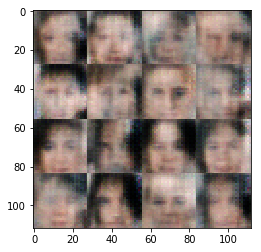

Epoch 1/1... Discriminator Loss: 0.2303... Generator Loss: 2.9826
Epoch 1/1... Discriminator Loss: 1.9047... Generator Loss: 1.2773
Epoch 1/1... Discriminator Loss: 2.5076... Generator Loss: 9.5918
Epoch 1/1... Discriminator Loss: 0.0637... Generator Loss: 10.2452
Epoch 1/1... Discriminator Loss: 0.0419... Generator Loss: 7.3444
Epoch 1/1... Discriminator Loss: 0.0300... Generator Loss: 11.2135
Epoch 1/1... Discriminator Loss: 0.0804... Generator Loss: 10.7825
Epoch 1/1... Discriminator Loss: 0.3163... Generator Loss: 5.4109
Epoch 1/1... Discriminator Loss: 0.3736... Generator Loss: 2.4362
Epoch 1/1... Discriminator Loss: 0.3414... Generator Loss: 3.6347


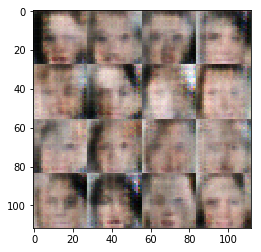

Epoch 1/1... Discriminator Loss: 0.3018... Generator Loss: 8.7338
Epoch 1/1... Discriminator Loss: 3.0956... Generator Loss: 0.0635
Epoch 1/1... Discriminator Loss: 0.6550... Generator Loss: 1.0255
Epoch 1/1... Discriminator Loss: 0.1654... Generator Loss: 8.5527
Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 1.3394
Epoch 1/1... Discriminator Loss: 0.1155... Generator Loss: 5.3644
Epoch 1/1... Discriminator Loss: 0.2453... Generator Loss: 7.9399
Epoch 1/1... Discriminator Loss: 0.1374... Generator Loss: 8.5181
Epoch 1/1... Discriminator Loss: 0.7191... Generator Loss: 13.1257
Epoch 1/1... Discriminator Loss: 0.3949... Generator Loss: 3.3107


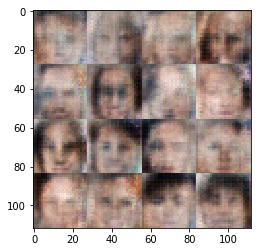

Epoch 1/1... Discriminator Loss: 0.8484... Generator Loss: 1.3475
Epoch 1/1... Discriminator Loss: 0.0650... Generator Loss: 6.9508
Epoch 1/1... Discriminator Loss: 0.0760... Generator Loss: 12.1669
Epoch 1/1... Discriminator Loss: 4.0922... Generator Loss: 6.9526
Epoch 1/1... Discriminator Loss: 0.1528... Generator Loss: 6.5160
Epoch 1/1... Discriminator Loss: 0.1615... Generator Loss: 8.9709
Epoch 1/1... Discriminator Loss: 0.1386... Generator Loss: 5.0800
Epoch 1/1... Discriminator Loss: 0.1145... Generator Loss: 6.5816
Epoch 1/1... Discriminator Loss: 0.3798... Generator Loss: 3.6372
Epoch 1/1... Discriminator Loss: 0.2041... Generator Loss: 7.7424


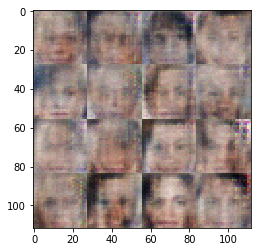

Epoch 1/1... Discriminator Loss: 0.7054... Generator Loss: 2.1866
Epoch 1/1... Discriminator Loss: 0.9764... Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 0.0211... Generator Loss: 10.6162
Epoch 1/1... Discriminator Loss: 0.6149... Generator Loss: 2.5260
Epoch 1/1... Discriminator Loss: 0.1563... Generator Loss: 7.7843
Epoch 1/1... Discriminator Loss: 0.1105... Generator Loss: 10.4381
Epoch 1/1... Discriminator Loss: 0.3170... Generator Loss: 3.7827
Epoch 1/1... Discriminator Loss: 0.1382... Generator Loss: 6.5301
Epoch 1/1... Discriminator Loss: 0.5295... Generator Loss: 6.5906
Epoch 1/1... Discriminator Loss: 0.0666... Generator Loss: 7.2341


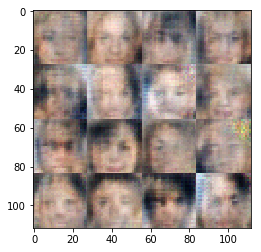

Epoch 1/1... Discriminator Loss: 2.6590... Generator Loss: 0.1306
Epoch 1/1... Discriminator Loss: 0.2661... Generator Loss: 6.8953
Epoch 1/1... Discriminator Loss: 0.1090... Generator Loss: 6.6823
Epoch 1/1... Discriminator Loss: 0.1976... Generator Loss: 7.9954
Epoch 1/1... Discriminator Loss: 0.1297... Generator Loss: 9.6508
Epoch 1/1... Discriminator Loss: 0.2180... Generator Loss: 9.4824
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 1.0391
Epoch 1/1... Discriminator Loss: 0.6591... Generator Loss: 8.4228
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 2.2938


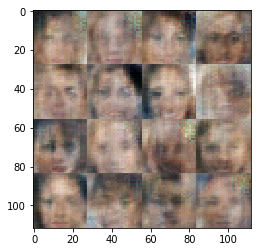

Epoch 1/1... Discriminator Loss: 0.1170... Generator Loss: 7.7894
Epoch 1/1... Discriminator Loss: 2.7215... Generator Loss: 1.2885
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 0.1273... Generator Loss: 8.8604
Epoch 1/1... Discriminator Loss: 2.0769... Generator Loss: 4.9106
Epoch 1/1... Discriminator Loss: 0.1586... Generator Loss: 6.1733
Epoch 1/1... Discriminator Loss: 0.5728... Generator Loss: 9.0487
Epoch 1/1... Discriminator Loss: 0.5902... Generator Loss: 1.2541
Epoch 1/1... Discriminator Loss: 0.1858... Generator Loss: 7.5378
Epoch 1/1... Discriminator Loss: 0.1647... Generator Loss: 10.7079


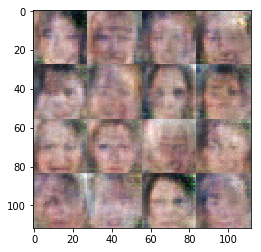

Epoch 1/1... Discriminator Loss: 0.0509... Generator Loss: 10.3301
Epoch 1/1... Discriminator Loss: 0.0698... Generator Loss: 8.1098
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 0.2930... Generator Loss: 3.2374
Epoch 1/1... Discriminator Loss: 5.0790... Generator Loss: 3.5114
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 3.1378
Epoch 1/1... Discriminator Loss: 1.5337... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 0.4774... Generator Loss: 1.9071
Epoch 1/1... Discriminator Loss: 0.4128... Generator Loss: 2.2401
Epoch 1/1... Discriminator Loss: 0.6628... Generator Loss: 5.3628


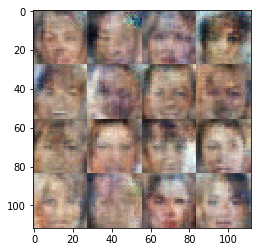

Epoch 1/1... Discriminator Loss: 0.5059... Generator Loss: 2.0723
Epoch 1/1... Discriminator Loss: 0.2028... Generator Loss: 6.0827
Epoch 1/1... Discriminator Loss: 0.1968... Generator Loss: 3.2504
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.4300
Epoch 1/1... Discriminator Loss: 0.2131... Generator Loss: 5.3357
Epoch 1/1... Discriminator Loss: 0.2874... Generator Loss: 2.6343
Epoch 1/1... Discriminator Loss: 1.8625... Generator Loss: 0.3144
Epoch 1/1... Discriminator Loss: 0.2270... Generator Loss: 3.4465
Epoch 1/1... Discriminator Loss: 1.7845... Generator Loss: 0.3449
Epoch 1/1... Discriminator Loss: 3.8307... Generator Loss: 0.4144


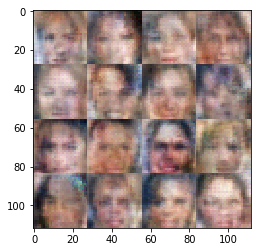

Epoch 1/1... Discriminator Loss: 1.8004... Generator Loss: 5.2539
Epoch 1/1... Discriminator Loss: 0.4025... Generator Loss: 1.9348
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 2.4210... Generator Loss: 0.1530
Epoch 1/1... Discriminator Loss: 1.9048... Generator Loss: 0.3196
Epoch 1/1... Discriminator Loss: 0.1341... Generator Loss: 5.1914
Epoch 1/1... Discriminator Loss: 0.3675... Generator Loss: 5.3232
Epoch 1/1... Discriminator Loss: 0.2267... Generator Loss: 3.8950
Epoch 1/1... Discriminator Loss: 0.5192... Generator Loss: 1.3484
Epoch 1/1... Discriminator Loss: 0.3034... Generator Loss: 8.6113


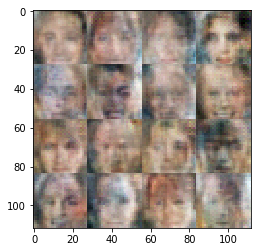

Epoch 1/1... Discriminator Loss: 0.9016... Generator Loss: 2.2201
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 1.2734
Epoch 1/1... Discriminator Loss: 1.7105... Generator Loss: 0.4780
Epoch 1/1... Discriminator Loss: 1.6203... Generator Loss: 0.4085
Epoch 1/1... Discriminator Loss: 1.5561... Generator Loss: 3.5232
Epoch 1/1... Discriminator Loss: 0.2857... Generator Loss: 2.8684
Epoch 1/1... Discriminator Loss: 0.3281... Generator Loss: 3.2890
Epoch 1/1... Discriminator Loss: 2.3494... Generator Loss: 0.1107
Epoch 1/1... Discriminator Loss: 0.6134... Generator Loss: 2.7984
Epoch 1/1... Discriminator Loss: 0.6377... Generator Loss: 2.3977


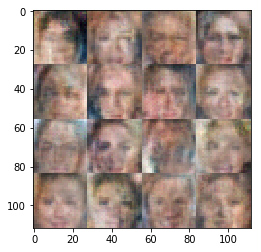

Epoch 1/1... Discriminator Loss: 0.5339... Generator Loss: 2.8626
Epoch 1/1... Discriminator Loss: 2.7129... Generator Loss: 4.5232
Epoch 1/1... Discriminator Loss: 0.3854... Generator Loss: 4.5604
Epoch 1/1... Discriminator Loss: 2.3728... Generator Loss: 0.3652
Epoch 1/1... Discriminator Loss: 0.7102... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 2.0847
Epoch 1/1... Discriminator Loss: 0.4271... Generator Loss: 2.0030
Epoch 1/1... Discriminator Loss: 0.4727... Generator Loss: 1.8454


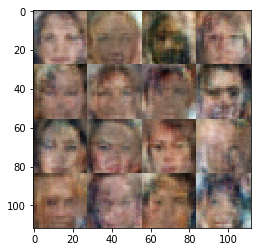

Epoch 1/1... Discriminator Loss: 0.2947... Generator Loss: 5.1141
Epoch 1/1... Discriminator Loss: 0.5660... Generator Loss: 3.1008
Epoch 1/1... Discriminator Loss: 0.6934... Generator Loss: 1.5451
Epoch 1/1... Discriminator Loss: 1.6691... Generator Loss: 1.8631
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.9787
Epoch 1/1... Discriminator Loss: 0.9708... Generator Loss: 0.9078
Epoch 1/1... Discriminator Loss: 0.3231... Generator Loss: 2.8982
Epoch 1/1... Discriminator Loss: 0.3724... Generator Loss: 2.5284
Epoch 1/1... Discriminator Loss: 2.0006... Generator Loss: 3.4456
Epoch 1/1... Discriminator Loss: 1.8518... Generator Loss: 0.2474


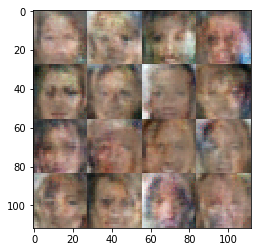

Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.4211
Epoch 1/1... Discriminator Loss: 0.5647... Generator Loss: 1.7718
Epoch 1/1... Discriminator Loss: 0.3199... Generator Loss: 2.8350
Epoch 1/1... Discriminator Loss: 2.5764... Generator Loss: 2.8794
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 0.5597... Generator Loss: 1.8026
Epoch 1/1... Discriminator Loss: 0.3826... Generator Loss: 3.2417
Epoch 1/1... Discriminator Loss: 0.4042... Generator Loss: 2.2449
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 5.0489


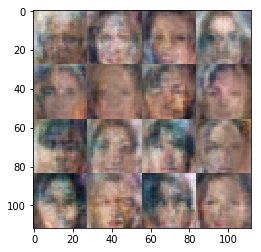

Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 1.3119
Epoch 1/1... Discriminator Loss: 0.6917... Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 2.0162... Generator Loss: 1.2832
Epoch 1/1... Discriminator Loss: 0.6905... Generator Loss: 1.2472
Epoch 1/1... Discriminator Loss: 0.7567... Generator Loss: 2.2612
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.5488
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.3674
Epoch 1/1... Discriminator Loss: 0.4658... Generator Loss: 2.7087
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 2.5531... Generator Loss: 2.8422


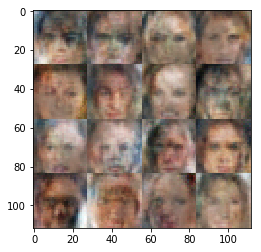

Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 0.9207
Epoch 1/1... Discriminator Loss: 0.5864... Generator Loss: 1.6246
Epoch 1/1... Discriminator Loss: 0.7696... Generator Loss: 1.2209
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 1.6062
Epoch 1/1... Discriminator Loss: 1.5239... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 0.4238... Generator Loss: 3.4359
Epoch 1/1... Discriminator Loss: 1.8345... Generator Loss: 0.2690
Epoch 1/1... Discriminator Loss: 2.0158... Generator Loss: 2.0039
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.4931
Epoch 1/1... Discriminator Loss: 2.4185... Generator Loss: 0.1655


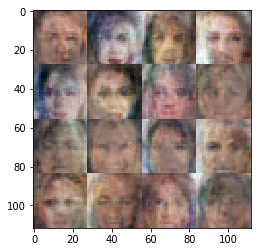

Epoch 1/1... Discriminator Loss: 0.7717... Generator Loss: 1.0767
Epoch 1/1... Discriminator Loss: 0.3139... Generator Loss: 3.6764
Epoch 1/1... Discriminator Loss: 0.9640... Generator Loss: 1.8141
Epoch 1/1... Discriminator Loss: 0.3986... Generator Loss: 2.7687
Epoch 1/1... Discriminator Loss: 1.9580... Generator Loss: 0.2195
Epoch 1/1... Discriminator Loss: 1.6406... Generator Loss: 0.2996
Epoch 1/1... Discriminator Loss: 0.3520... Generator Loss: 2.7841
Epoch 1/1... Discriminator Loss: 0.9185... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 2.3437
Epoch 1/1... Discriminator Loss: 0.3658... Generator Loss: 2.5394


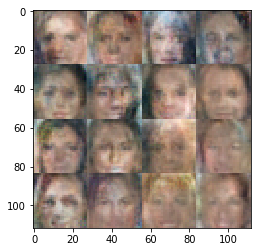

Epoch 1/1... Discriminator Loss: 1.5789... Generator Loss: 2.6602
Epoch 1/1... Discriminator Loss: 0.6760... Generator Loss: 1.5944
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 3.4046
Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 1.9779
Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.3599
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.4917
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 1.9371
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 1.9478
Epoch 1/1... Discriminator Loss: 1.9769... Generator Loss: 0.2518
Epoch 1/1... Discriminator Loss: 0.9183... Generator Loss: 1.7443


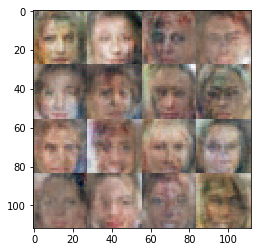

Epoch 1/1... Discriminator Loss: 0.8093... Generator Loss: 2.2120
Epoch 1/1... Discriminator Loss: 0.3780... Generator Loss: 5.6624
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.9690
Epoch 1/1... Discriminator Loss: 0.7630... Generator Loss: 1.3342
Epoch 1/1... Discriminator Loss: 1.6287... Generator Loss: 0.3913
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 0.8453... Generator Loss: 7.3459
Epoch 1/1... Discriminator Loss: 0.2301... Generator Loss: 4.9973
Epoch 1/1... Discriminator Loss: 1.9031... Generator Loss: 0.3031
Epoch 1/1... Discriminator Loss: 0.4395... Generator Loss: 2.5265


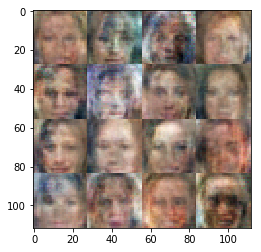

Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 0.4746... Generator Loss: 3.7419
Epoch 1/1... Discriminator Loss: 2.1915... Generator Loss: 0.4745
Epoch 1/1... Discriminator Loss: 0.4168... Generator Loss: 2.1589
Epoch 1/1... Discriminator Loss: 0.6600... Generator Loss: 1.1570
Epoch 1/1... Discriminator Loss: 2.4814... Generator Loss: 0.1089
Epoch 1/1... Discriminator Loss: 0.4972... Generator Loss: 3.8737
Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 3.4175
Epoch 1/1... Discriminator Loss: 0.1734... Generator Loss: 4.3739
Epoch 1/1... Discriminator Loss: 1.7015... Generator Loss: 0.2703


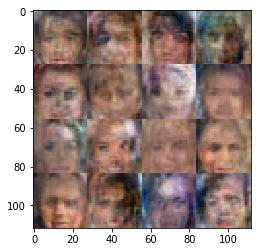

Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.5991... Generator Loss: 1.4176
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 1.3930
Epoch 1/1... Discriminator Loss: 2.0421... Generator Loss: 1.4519
Epoch 1/1... Discriminator Loss: 0.5149... Generator Loss: 1.7601
Epoch 1/1... Discriminator Loss: 0.2700... Generator Loss: 4.1105
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.5181
Epoch 1/1... Discriminator Loss: 3.5790... Generator Loss: 3.3282
Epoch 1/1... Discriminator Loss: 1.7753... Generator Loss: 2.4835
Epoch 1/1... Discriminator Loss: 3.7759... Generator Loss: 5.2019


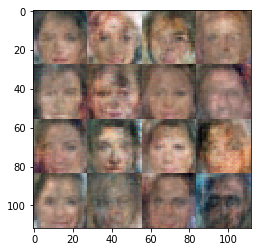

Epoch 1/1... Discriminator Loss: 0.7140... Generator Loss: 2.1644
Epoch 1/1... Discriminator Loss: 0.7830... Generator Loss: 1.0945
Epoch 1/1... Discriminator Loss: 2.3899... Generator Loss: 0.1380
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.5480
Epoch 1/1... Discriminator Loss: 2.9017... Generator Loss: 2.0881
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 3.5566
Epoch 1/1... Discriminator Loss: 0.6688... Generator Loss: 1.0632
Epoch 1/1... Discriminator Loss: 0.7698... Generator Loss: 1.8127
Epoch 1/1... Discriminator Loss: 1.9026... Generator Loss: 0.2507


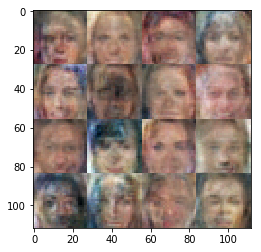

Epoch 1/1... Discriminator Loss: 0.8415... Generator Loss: 2.8334
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 3.0958
Epoch 1/1... Discriminator Loss: 0.7167... Generator Loss: 3.5903
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.5049
Epoch 1/1... Discriminator Loss: 1.5538... Generator Loss: 0.3931
Epoch 1/1... Discriminator Loss: 1.8124... Generator Loss: 0.4406
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 1.1201
Epoch 1/1... Discriminator Loss: 0.3149... Generator Loss: 3.1095
Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 0.6145... Generator Loss: 5.0853


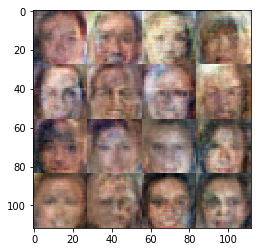

Epoch 1/1... Discriminator Loss: 1.7818... Generator Loss: 0.2265
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.4425
Epoch 1/1... Discriminator Loss: 0.3693... Generator Loss: 2.1015
Epoch 1/1... Discriminator Loss: 2.3836... Generator Loss: 2.3518
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 0.8284... Generator Loss: 5.1878
Epoch 1/1... Discriminator Loss: 0.3218... Generator Loss: 2.7255
Epoch 1/1... Discriminator Loss: 0.9369... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.5614... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.6072


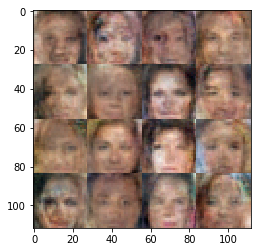

Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 0.9503
Epoch 1/1... Discriminator Loss: 0.5799... Generator Loss: 1.4616
Epoch 1/1... Discriminator Loss: 0.7366... Generator Loss: 1.3431
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 1.8502
Epoch 1/1... Discriminator Loss: 0.6228... Generator Loss: 1.5753
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 1.6434
Epoch 1/1... Discriminator Loss: 0.1939... Generator Loss: 2.4572
Epoch 1/1... Discriminator Loss: 0.7672... Generator Loss: 3.2614
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.4312
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 1.1529


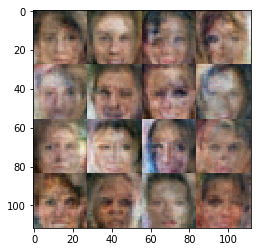

Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 0.4580
Epoch 1/1... Discriminator Loss: 1.7776... Generator Loss: 0.2420
Epoch 1/1... Discriminator Loss: 0.6541... Generator Loss: 1.7332
Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 2.9911
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 0.2911... Generator Loss: 3.0920
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.5080
Epoch 1/1... Discriminator Loss: 0.5123... Generator Loss: 2.2652
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 5.0472


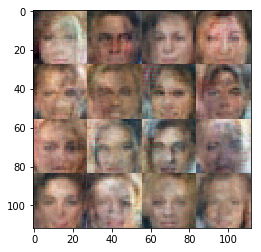

Epoch 1/1... Discriminator Loss: 0.3547... Generator Loss: 2.4350
Epoch 1/1... Discriminator Loss: 0.3437... Generator Loss: 1.7725
Epoch 1/1... Discriminator Loss: 1.8846... Generator Loss: 0.2247
Epoch 1/1... Discriminator Loss: 0.5945... Generator Loss: 3.2376
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 1.2194
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.4575
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 1.5130
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 1.0554
Epoch 1/1... Discriminator Loss: 0.4363... Generator Loss: 2.4986
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.5307


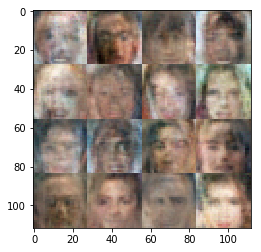

Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 0.5926
Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 0.6349
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 2.0995
Epoch 1/1... Discriminator Loss: 0.2942... Generator Loss: 2.0850
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.4120
Epoch 1/1... Discriminator Loss: 0.4367... Generator Loss: 1.8420
Epoch 1/1... Discriminator Loss: 1.5858... Generator Loss: 0.3757
Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 1.0927
Epoch 1/1... Discriminator Loss: 0.7192... Generator Loss: 1.0338


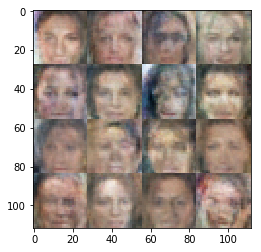

Epoch 1/1... Discriminator Loss: 0.4101... Generator Loss: 1.6955
Epoch 1/1... Discriminator Loss: 0.5020... Generator Loss: 3.4055
Epoch 1/1... Discriminator Loss: 0.3267... Generator Loss: 2.1648
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 0.3477... Generator Loss: 2.5919
Epoch 1/1... Discriminator Loss: 0.2283... Generator Loss: 2.9112
Epoch 1/1... Discriminator Loss: 2.3612... Generator Loss: 0.1262
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.4750
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 1.2878
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 0.6203


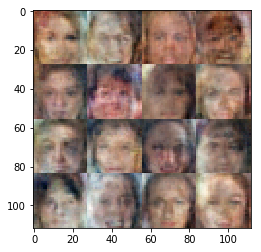

Epoch 1/1... Discriminator Loss: 0.8263... Generator Loss: 1.4620
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 2.1982
Epoch 1/1... Discriminator Loss: 1.6083... Generator Loss: 0.3787
Epoch 1/1... Discriminator Loss: 2.3970... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 0.8860... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.7864... Generator Loss: 0.2775
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.4383
Epoch 1/1... Discriminator Loss: 2.4493... Generator Loss: 2.4433
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 2.4816
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.5637


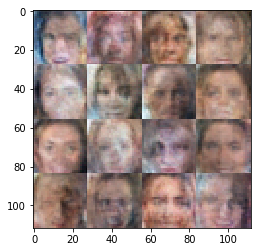

Epoch 1/1... Discriminator Loss: 0.6627... Generator Loss: 1.7751
Epoch 1/1... Discriminator Loss: 1.7944... Generator Loss: 2.0606
Epoch 1/1... Discriminator Loss: 0.2963... Generator Loss: 2.0025
Epoch 1/1... Discriminator Loss: 0.3067... Generator Loss: 2.2057
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 0.3608... Generator Loss: 1.7312
Epoch 1/1... Discriminator Loss: 0.8757... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.3973
Epoch 1/1... Discriminator Loss: 0.5318... Generator Loss: 2.5127
Epoch 1/1... Discriminator Loss: 0.9481... Generator Loss: 2.9848


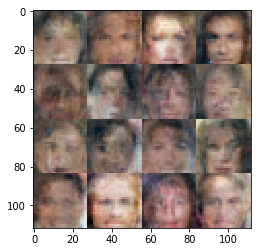

Epoch 1/1... Discriminator Loss: 0.2861... Generator Loss: 2.4216
Epoch 1/1... Discriminator Loss: 0.8568... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 0.7425... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 0.8904... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.3327
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 1.6090
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.4068
Epoch 1/1... Discriminator Loss: 0.6946... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 0.6360... Generator Loss: 1.6450


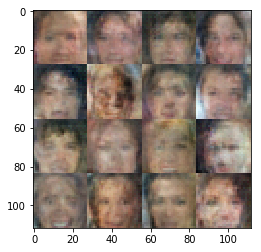

Epoch 1/1... Discriminator Loss: 2.2098... Generator Loss: 2.4687
Epoch 1/1... Discriminator Loss: 1.8880... Generator Loss: 0.2698
Epoch 1/1... Discriminator Loss: 1.7710... Generator Loss: 0.3533
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.4575
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 1.0923
Epoch 1/1... Discriminator Loss: 0.7971... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 1.4993
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 0.8235... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 0.6347... Generator Loss: 1.7277


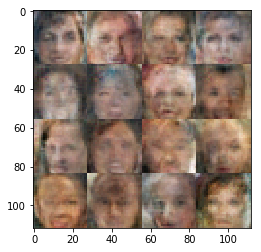

Epoch 1/1... Discriminator Loss: 2.2222... Generator Loss: 0.1475
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 1.3677
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 1.3652
Epoch 1/1... Discriminator Loss: 1.5749... Generator Loss: 0.4680
Epoch 1/1... Discriminator Loss: 0.5917... Generator Loss: 1.2907
Epoch 1/1... Discriminator Loss: 1.7200... Generator Loss: 2.3490
Epoch 1/1... Discriminator Loss: 1.5382... Generator Loss: 0.3961
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.4732


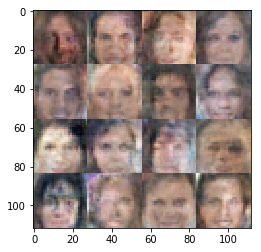

Epoch 1/1... Discriminator Loss: 1.5516... Generator Loss: 0.3002
Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 1.6612
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.4505
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 2.5506
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 0.6463... Generator Loss: 1.2911
Epoch 1/1... Discriminator Loss: 0.6809... Generator Loss: 1.7716


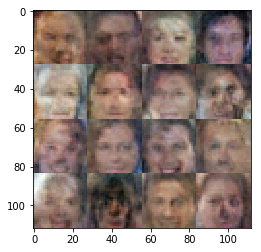

Epoch 1/1... Discriminator Loss: 0.6647... Generator Loss: 1.3907
Epoch 1/1... Discriminator Loss: 0.6251... Generator Loss: 1.6732
Epoch 1/1... Discriminator Loss: 0.7516... Generator Loss: 1.4693
Epoch 1/1... Discriminator Loss: 0.6655... Generator Loss: 1.5560
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.8774... Generator Loss: 0.3087
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 1.0388
Epoch 1/1... Discriminator Loss: 1.6891... Generator Loss: 0.3354
Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 1.8514


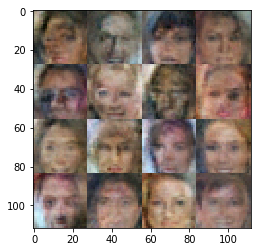

Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 2.2280
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 1.8531
Epoch 1/1... Discriminator Loss: 0.4708... Generator Loss: 3.0319
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 1.3463
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 0.8585... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.5376


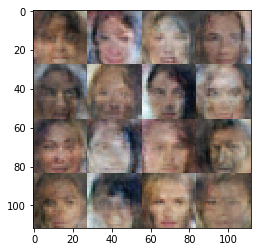

Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.5580... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 0.7533... Generator Loss: 1.0123
Epoch 1/1... Discriminator Loss: 1.6979... Generator Loss: 1.6495
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 1.2940
Epoch 1/1... Discriminator Loss: 1.6391... Generator Loss: 0.2773
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.4114
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.6336


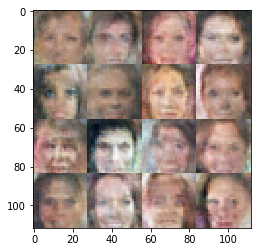

Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.5870
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.3698
Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 1.0811
Epoch 1/1... Discriminator Loss: 0.3044... Generator Loss: 1.9980
Epoch 1/1... Discriminator Loss: 2.0323... Generator Loss: 1.5973
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.5326... Generator Loss: 0.3312
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 1.6958... Generator Loss: 0.2906
Epoch 1/1... Discriminator Loss: 0.9627... Generator Loss: 0.6458


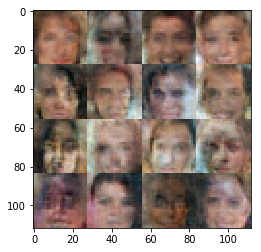

Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 0.9223... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 0.7845... Generator Loss: 1.3068
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 1.1897
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 0.7763... Generator Loss: 1.0374
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 1.9146
Epoch 1/1... Discriminator Loss: 1.7873... Generator Loss: 0.2958
Epoch 1/1... Discriminator Loss: 1.5428... Generator Loss: 0.4333
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.4832


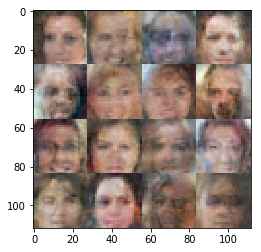

Epoch 1/1... Discriminator Loss: 1.5988... Generator Loss: 0.2882
Epoch 1/1... Discriminator Loss: 0.4216... Generator Loss: 1.7588
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 1.5631
Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.3438
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.4176
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 1.1920
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 2.0465
Epoch 1/1... Discriminator Loss: 1.0834... Generator Loss: 0.6397


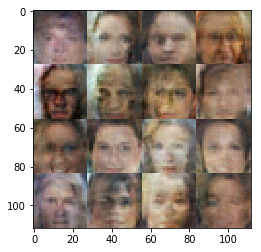

Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 0.8879... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.5497... Generator Loss: 0.3506
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 0.7616... Generator Loss: 1.2540
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 1.2736
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.5393
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 0.5970... Generator Loss: 1.3133


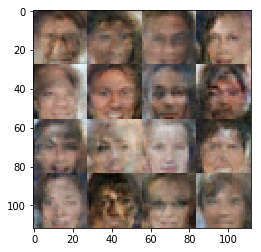

Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 0.6167... Generator Loss: 1.1788
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 0.9642
Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 0.6860... Generator Loss: 1.3226
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.3221
Epoch 1/1... Discriminator Loss: 0.7627... Generator Loss: 1.1237
Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 1.3117
Epoch 1/1... Discriminator Loss: 0.6877... Generator Loss: 2.1972


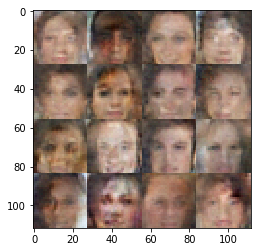

Epoch 1/1... Discriminator Loss: 1.7050... Generator Loss: 1.8249
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 0.9863
Epoch 1/1... Discriminator Loss: 1.7846... Generator Loss: 1.4218
Epoch 1/1... Discriminator Loss: 0.8087... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.4418
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 1.5857
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.4169
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 1.2229
Epoch 1/1... Discriminator Loss: 0.7500... Generator Loss: 1.2373


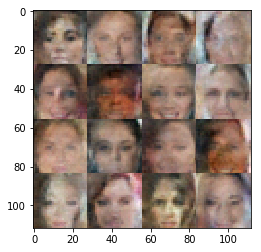

Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 0.5457
Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 0.9673
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 0.4284
Epoch 1/1... Discriminator Loss: 1.0283... Generator Loss: 0.5882
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 0.8970
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.3499
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 0.9395... Generator Loss: 0.8784


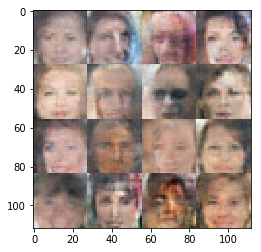

Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.9317... Generator Loss: 0.1949
Epoch 1/1... Discriminator Loss: 1.5182... Generator Loss: 0.5002
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.4949
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 1.2300
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 0.8695


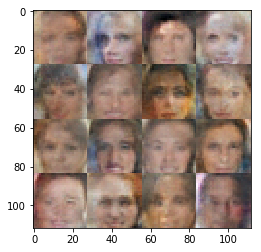

Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.3347
Epoch 1/1... Discriminator Loss: 0.7325... Generator Loss: 1.2605
Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 1.1789
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.5108
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.4813
Epoch 1/1... Discriminator Loss: 1.6450... Generator Loss: 0.2593
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.5143
Epoch 1/1... Discriminator Loss: 0.7718... Generator Loss: 1.3441


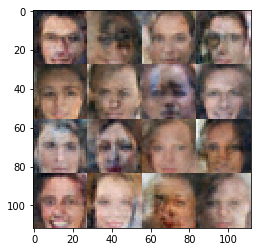

Epoch 1/1... Discriminator Loss: 1.1841... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.3807
Epoch 1/1... Discriminator Loss: 0.9520... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 0.7338... Generator Loss: 2.0461
Epoch 1/1... Discriminator Loss: 2.2404... Generator Loss: 0.1567
Epoch 1/1... Discriminator Loss: 1.6797... Generator Loss: 0.3064
Epoch 1/1... Discriminator Loss: 1.9179... Generator Loss: 0.2577
Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 1.0454
Epoch 1/1... Discriminator Loss: 0.9442... Generator Loss: 1.2094


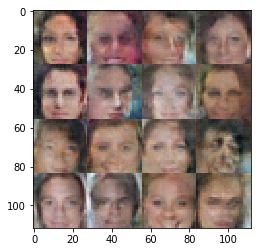

Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 0.6502... Generator Loss: 1.3772
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 1.4461
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 0.8395... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 1.1663
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 1.3258
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.6251


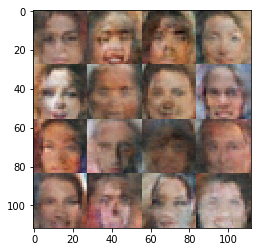

Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.4481
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 0.9549... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.3501
Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 1.0344
Epoch 1/1... Discriminator Loss: 0.9543... Generator Loss: 0.9266
Epoch 1/1... Discriminator Loss: 1.5902... Generator Loss: 0.2905
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.9810


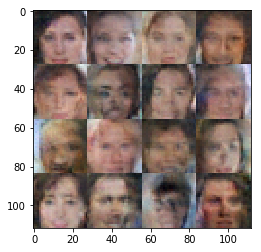

Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.3257
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.4323
Epoch 1/1... Discriminator Loss: 1.6786... Generator Loss: 0.2575
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.4738
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 0.5231


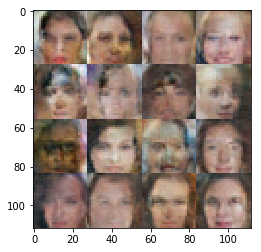

Epoch 1/1... Discriminator Loss: 0.9357... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.8382... Generator Loss: 0.2507
Epoch 1/1... Discriminator Loss: 1.6517... Generator Loss: 0.2502
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 1.3979
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 1.7093
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.8503... Generator Loss: 0.2486
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.4339
Epoch 1/1... Discriminator Loss: 0.7847... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 0.9853


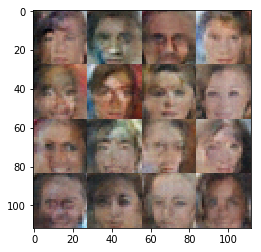

Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 1.0043
Epoch 1/1... Discriminator Loss: 2.1584... Generator Loss: 0.1559
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.3869
Epoch 1/1... Discriminator Loss: 1.6561... Generator Loss: 0.3205
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 0.8235... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 0.7259


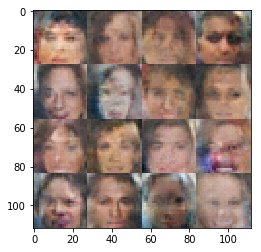

Epoch 1/1... Discriminator Loss: 1.0598... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 1.4669
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.5175
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.7516... Generator Loss: 0.5120
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.2937
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.4926
Epoch 1/1... Discriminator Loss: 1.9302... Generator Loss: 0.1829
Epoch 1/1... Discriminator Loss: 1.0041... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.7451


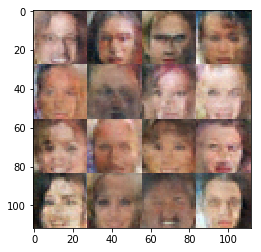

Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 1.1258
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 1.4446
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.5511
Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 1.0806
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.5607


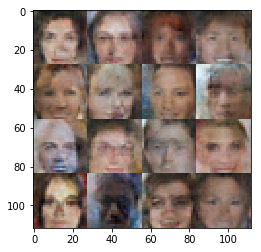

Epoch 1/1... Discriminator Loss: 1.6849... Generator Loss: 0.2711
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 1.3940
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.3872
Epoch 1/1... Discriminator Loss: 0.7946... Generator Loss: 1.7411
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 1.2852
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 0.5263
Epoch 1/1... Discriminator Loss: 1.9731... Generator Loss: 0.2076
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.4426


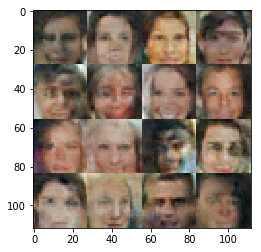

Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.3306
Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.4724
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 2.0258
Epoch 1/1... Discriminator Loss: 1.8199... Generator Loss: 0.2685
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.3389
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 1.9653
Epoch 1/1... Discriminator Loss: 1.5448... Generator Loss: 0.3048


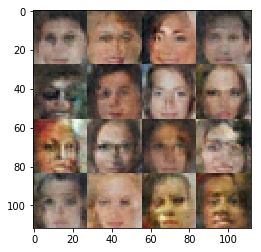

Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.4711
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 1.1876
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 1.5231
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 1.5696
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.6045... Generator Loss: 0.2758
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 1.6217... Generator Loss: 0.2674


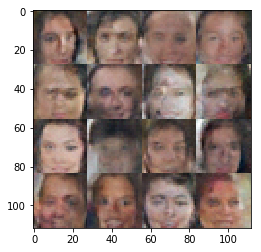

Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.6729... Generator Loss: 0.4499
Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 0.4954
Epoch 1/1... Discriminator Loss: 1.5295... Generator Loss: 0.2937
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 0.4877
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.4016
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.3810
Epoch 1/1... Discriminator Loss: 0.8316... Generator Loss: 1.8558


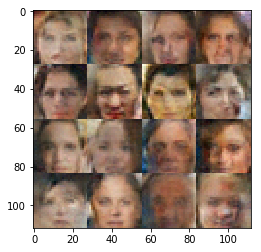

Epoch 1/1... Discriminator Loss: 0.7126... Generator Loss: 1.3622
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 1.2739
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 1.0682
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.3875
Epoch 1/1... Discriminator Loss: 1.5670... Generator Loss: 0.3261
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 2.0780... Generator Loss: 0.1838
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 1.0953


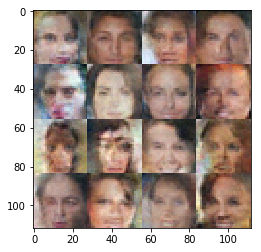

Epoch 1/1... Discriminator Loss: 1.5650... Generator Loss: 0.3209
Epoch 1/1... Discriminator Loss: 1.7964... Generator Loss: 0.2133
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.4978
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.4834
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.3626
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 1.6545
Epoch 1/1... Discriminator Loss: 2.0110... Generator Loss: 0.1738
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.7539


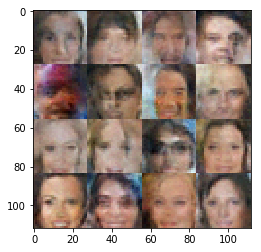

Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.3692
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.4096
Epoch 1/1... Discriminator Loss: 1.6134... Generator Loss: 0.3255
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.3471
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.3724
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.4852
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.6042... Generator Loss: 0.2738
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.8963


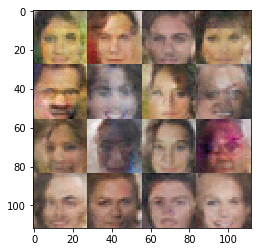

Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.3473
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.3587
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.4271
Epoch 1/1... Discriminator Loss: 0.8549... Generator Loss: 1.3417
Epoch 1/1... Discriminator Loss: 1.8724... Generator Loss: 0.2470
Epoch 1/1... Discriminator Loss: 2.0317... Generator Loss: 0.1821
Epoch 1/1... Discriminator Loss: 0.8807... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.4998
Epoch 1/1... Discriminator Loss: 2.1774... Generator Loss: 0.1305


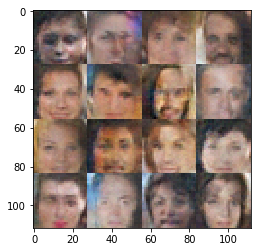

Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.5407
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.4771
Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.3225
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.4802
Epoch 1/1... Discriminator Loss: 1.5880... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.3972
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.5183
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.8522


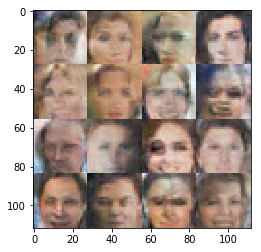

Epoch 1/1... Discriminator Loss: 1.6376... Generator Loss: 1.5746
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.4779
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 0.7329... Generator Loss: 1.0006
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.3636
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.5992... Generator Loss: 0.3138
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 1.5122
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 1.1137
Epoch 1/1... Discriminator Loss: 1.6759... Generator Loss: 0.2857


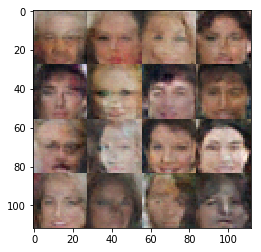

Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.5089
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 1.1947
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.3398
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.3980
Epoch 1/1... Discriminator Loss: 1.7997... Generator Loss: 0.2305
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 0.3524
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 0.8938


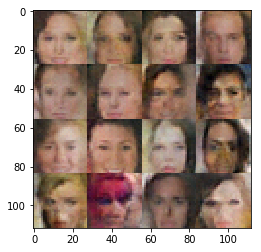

Epoch 1/1... Discriminator Loss: 1.8215... Generator Loss: 0.2068
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.6000
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.4707
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 1.7717
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.4807
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.4122
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.4442
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.3727
Epoch 1/1... Discriminator Loss: 1.5347... Generator Loss: 0.3548


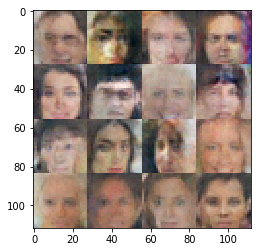

Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.8387... Generator Loss: 0.2121
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.5394
Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 0.3125
Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 1.1303
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 1.4244
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 1.3816
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.4403
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.6148


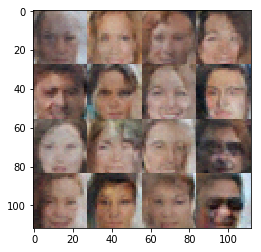

Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.4863
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.3322
Epoch 1/1... Discriminator Loss: 0.9559... Generator Loss: 1.3521
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 1.0834
Epoch 1/1... Discriminator Loss: 1.6589... Generator Loss: 1.0587
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.5607... Generator Loss: 0.3050
Epoch 1/1... Discriminator Loss: 1.7491... Generator Loss: 1.9130
Epoch 1/1... Discriminator Loss: 1.6305... Generator Loss: 0.2603


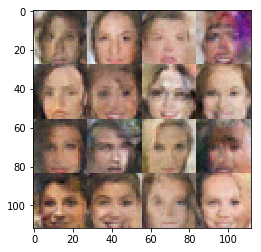

Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.4703
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.4369
Epoch 1/1... Discriminator Loss: 0.7686... Generator Loss: 1.4414
Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.3040
Epoch 1/1... Discriminator Loss: 1.2071... Generator Loss: 1.1380
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 1.2480
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.5136
Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 0.3367
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 2.0187


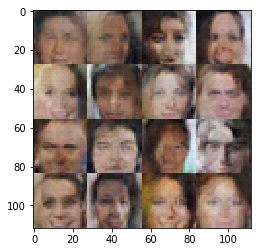

Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.5555
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.3550
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 1.0139
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.3674
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 1.3125
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.5782... Generator Loss: 0.2777


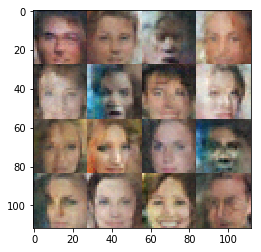

Epoch 1/1... Discriminator Loss: 1.8470... Generator Loss: 0.2402
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 1.3367
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 1.9643
Epoch 1/1... Discriminator Loss: 1.8306... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.5518... Generator Loss: 0.2756
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 1.7736... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.3720
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.4766


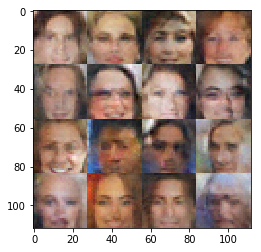

Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.3727
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.5199... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.6829... Generator Loss: 0.2701
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 0.9123... Generator Loss: 1.5479
Epoch 1/1... Discriminator Loss: 1.6060... Generator Loss: 0.3390
Epoch 1/1... Discriminator Loss: 2.0180... Generator Loss: 0.1884
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.4094


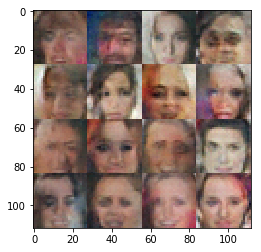

Epoch 1/1... Discriminator Loss: 2.5728... Generator Loss: 0.0881
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 0.5178
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.5044
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.3675
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.3270
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 1.4517
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 1.5014


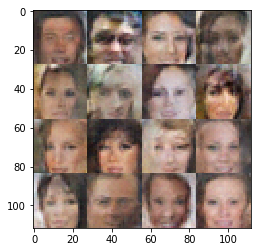

Epoch 1/1... Discriminator Loss: 1.7809... Generator Loss: 0.2673
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.9586... Generator Loss: 0.1886
Epoch 1/1... Discriminator Loss: 1.8630... Generator Loss: 0.2192
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.5338
Epoch 1/1... Discriminator Loss: 1.5520... Generator Loss: 0.2832
Epoch 1/1... Discriminator Loss: 1.5808... Generator Loss: 0.3171
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.4579
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.6136


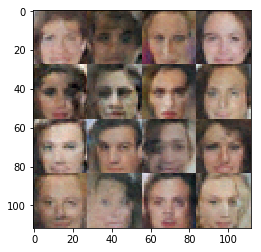

Epoch 1/1... Discriminator Loss: 1.5762... Generator Loss: 0.3052
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 1.2815
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 1.4808
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.3962
Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 1.7445
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.4148


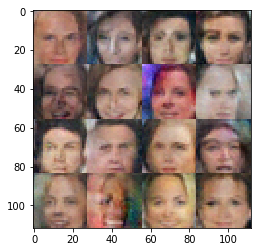

Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 0.9424... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 1.6951... Generator Loss: 0.2534
Epoch 1/1... Discriminator Loss: 1.6521... Generator Loss: 0.3462
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 1.1137
Epoch 1/1... Discriminator Loss: 1.7382... Generator Loss: 0.2739
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 1.7252
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 0.9402... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 0.9888


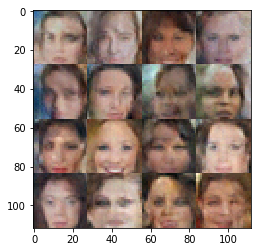

Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.6049
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.5038
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.5538
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.7079... Generator Loss: 0.2385
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 1.1132
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.2836
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.6718... Generator Loss: 0.2530
Epoch 1/1... Discriminator Loss: 1.9560... Generator Loss: 0.2176


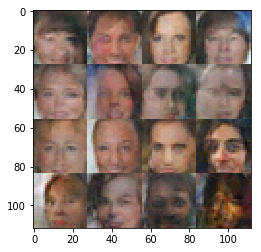

Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.5029
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 1.0498
Epoch 1/1... Discriminator Loss: 1.5494... Generator Loss: 0.3640
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 1.5814
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.4504


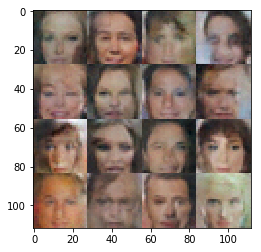

Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.8931... Generator Loss: 0.1903
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.4307
Epoch 1/1... Discriminator Loss: 1.6892... Generator Loss: 0.2810
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 1.5906... Generator Loss: 0.2751
Epoch 1/1... Discriminator Loss: 1.5746... Generator Loss: 0.2811
Epoch 1/1... Discriminator Loss: 0.8307... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.6696... Generator Loss: 0.2883


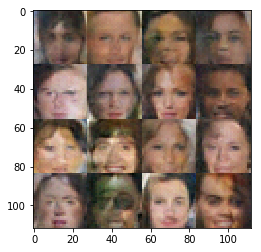

Epoch 1/1... Discriminator Loss: 1.0598... Generator Loss: 1.9072
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 2.0703... Generator Loss: 0.1795
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.5362
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.3651
Epoch 1/1... Discriminator Loss: 1.6256... Generator Loss: 1.3173
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 1.3701
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 0.4982


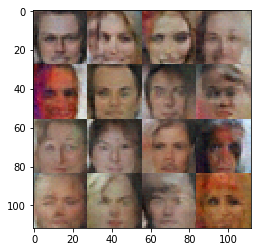

Epoch 1/1... Discriminator Loss: 1.7274... Generator Loss: 0.2587
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.3483
Epoch 1/1... Discriminator Loss: 1.8508... Generator Loss: 0.2571
Epoch 1/1... Discriminator Loss: 2.3462... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 0.9475
Epoch 1/1... Discriminator Loss: 1.5798... Generator Loss: 0.3008
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.8480... Generator Loss: 0.2269
Epoch 1/1... Discriminator Loss: 1.6809... Generator Loss: 0.3170
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.6366


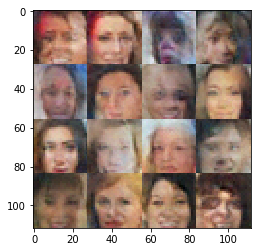

Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 0.4507
Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.4780
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.6076... Generator Loss: 0.3154
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.3750
Epoch 1/1... Discriminator Loss: 0.8289... Generator Loss: 0.9278


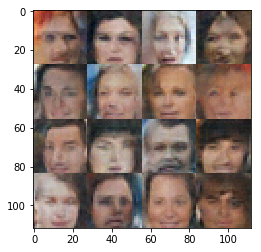

Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 1.9786
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 1.1153
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.5039
Epoch 1/1... Discriminator Loss: 1.7031... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 1.2623
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.3837
Epoch 1/1... Discriminator Loss: 1.0107... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 0.9758
Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.4180
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 1.2712


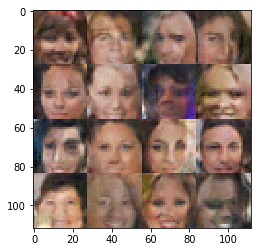

Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.3818
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 1.8238... Generator Loss: 0.2331
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.4895
Epoch 1/1... Discriminator Loss: 1.8900... Generator Loss: 0.2238
Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 1.4307
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.3341


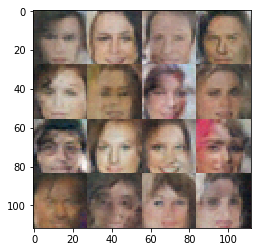

Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.3964
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 1.7185... Generator Loss: 0.2815
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.4392
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.4909
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.4780
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.4180


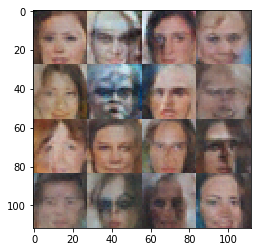

Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.5001
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.6473... Generator Loss: 0.2893
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.4805
Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 0.3125
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.4157
Epoch 1/1... Discriminator Loss: 1.5908... Generator Loss: 0.3478
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.9753


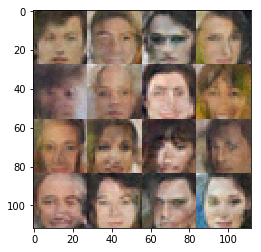

Epoch 1/1... Discriminator Loss: 1.7046... Generator Loss: 0.2558
Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.6524... Generator Loss: 1.4769
Epoch 1/1... Discriminator Loss: 1.6829... Generator Loss: 1.3918
Epoch 1/1... Discriminator Loss: 1.5369... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.4024
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.7908... Generator Loss: 0.2472
Epoch 1/1... Discriminator Loss: 1.6056... Generator Loss: 0.3955


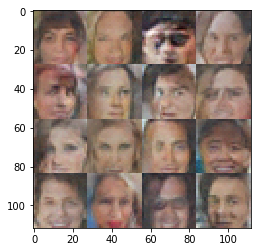

Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.3551
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.5396
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.5463
Epoch 1/1... Discriminator Loss: 1.5996... Generator Loss: 0.3239
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.4656
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 1.2185
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.4011
Epoch 1/1... Discriminator Loss: 1.5707... Generator Loss: 1.3777
Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 1.0695
Epoch 1/1... Discriminator Loss: 1.7872... Generator Loss: 0.2198


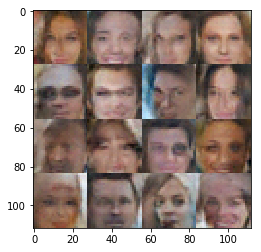

Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 2.6789... Generator Loss: 0.1119
Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.4266
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.3280
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.5207
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.4630
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.3663


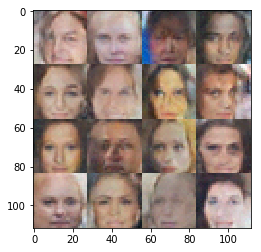

Epoch 1/1... Discriminator Loss: 1.6022... Generator Loss: 0.3003
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 0.8784
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.4215
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.4789
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.4481
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.4210
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.5271
Epoch 1/1... Discriminator Loss: 0.9157... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.4491


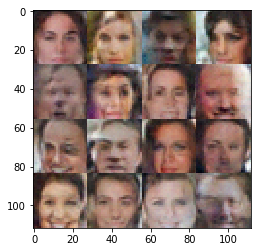

Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.6757... Generator Loss: 0.2566
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 0.8100... Generator Loss: 1.5634
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 1.1057
Epoch 1/1... Discriminator Loss: 1.6480... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.3550


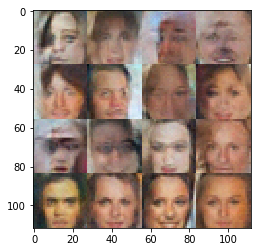

Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.4848
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.4294
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.4908
Epoch 1/1... Discriminator Loss: 2.1805... Generator Loss: 1.5100
Epoch 1/1... Discriminator Loss: 0.7281... Generator Loss: 1.6466
Epoch 1/1... Discriminator Loss: 2.2063... Generator Loss: 0.2778
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.5018
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.4715
Epoch 1/1... Discriminator Loss: 1.5544... Generator Loss: 0.3314
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7292


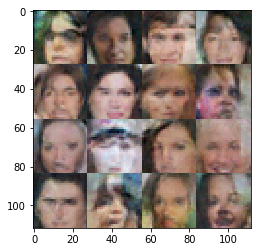

Epoch 1/1... Discriminator Loss: 0.7728... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 1.6077... Generator Loss: 0.2736
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.4739
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.4625
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.4293


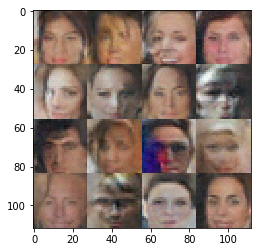

Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 0.9442


In [14]:
batch_size = 20
z_dim = 100
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.